# Image segmentation using Vanilla UNet, UNet with ResNeXt50 backbone, and Feature Pyramid Network.

**Steps**:
+ **Data Preparation**

+ **Data Visualization**

+ **Data Augmentaions**

+ **FPN**

+ **UNet ResNeXt50**

+ **Train Models**

+ **Prediction on test data**

+ **Visualization of the prediction on test data**


In [1]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid

plt.style.use("dark_background")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  if sys.path[0] == '':


Global Variable

In [2]:
# Path to all data
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

# Data

## Creating a DataFrame

In [3]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


dirname                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [4]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_23.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_23_mask.tif


Final dataframe

In [5]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

patient  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
...                                                 ...        ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  

[3929 rows x 4 columns]

## Data Distribution

Distribution of positive/negative diagnosis

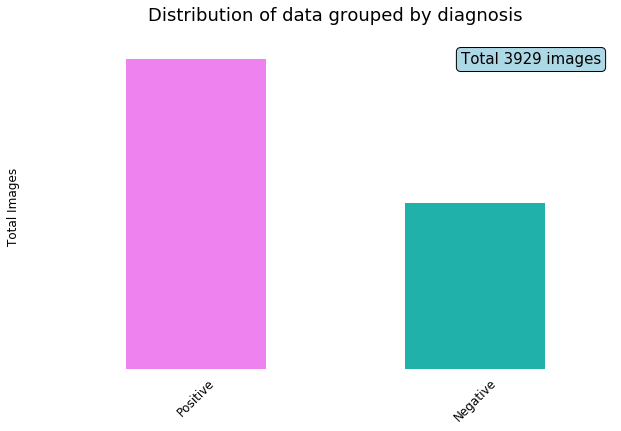

In [6]:
import matplotlib.pyplot as plt

# Plot
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
df.diagnosis.value_counts().plot(kind='bar', stacked=True, color=["violet", "lightseagreen"], ax=ax)

# Set background color for the plot area
ax.set_facecolor('white')

# Set x-tick labels, y-label, and title
ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12, color='black')
ax.set_ylabel('Total Images', fontsize=12, color='black')
ax.set_title("Distribution of data grouped by diagnosis", fontsize=18, y=1.05, color='black')

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows - 12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")

# Add text box
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
        ha="center", va="center",
        bbox=dict(boxstyle="round",
                  fc=("lightblue"),
                  ec=("black")))

# Show plot
plt.show()

Distribution of positive/negative diagnosis between each patient

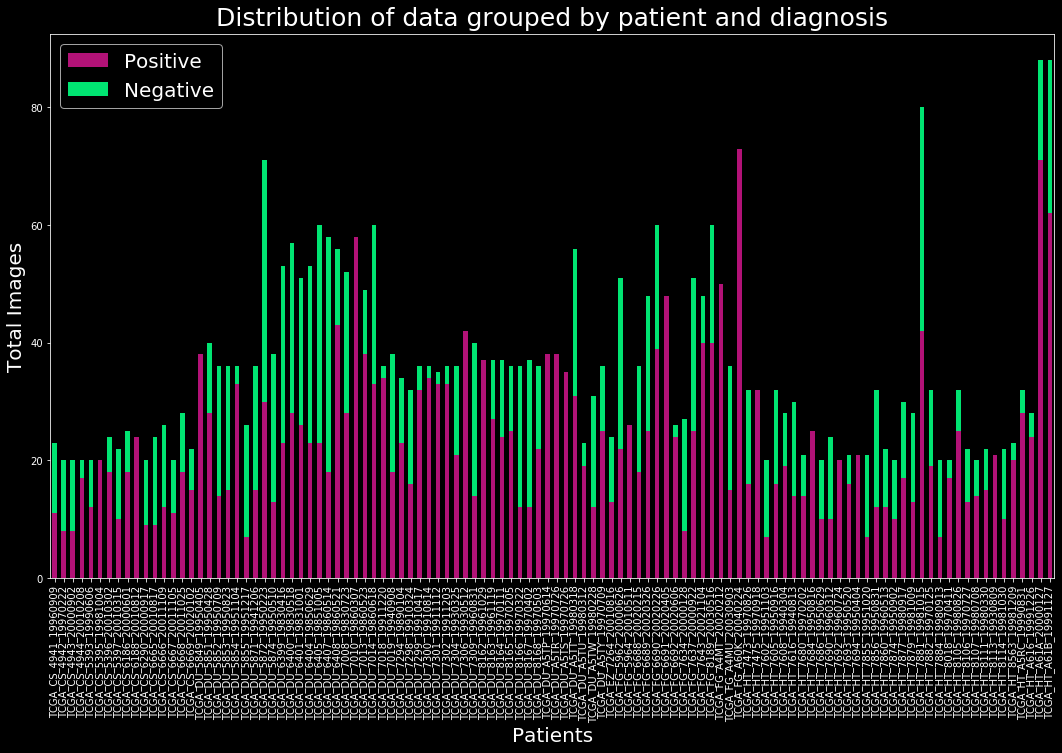

In [7]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

## Data Visualization

Samples of images with a positive and negative diagnosis

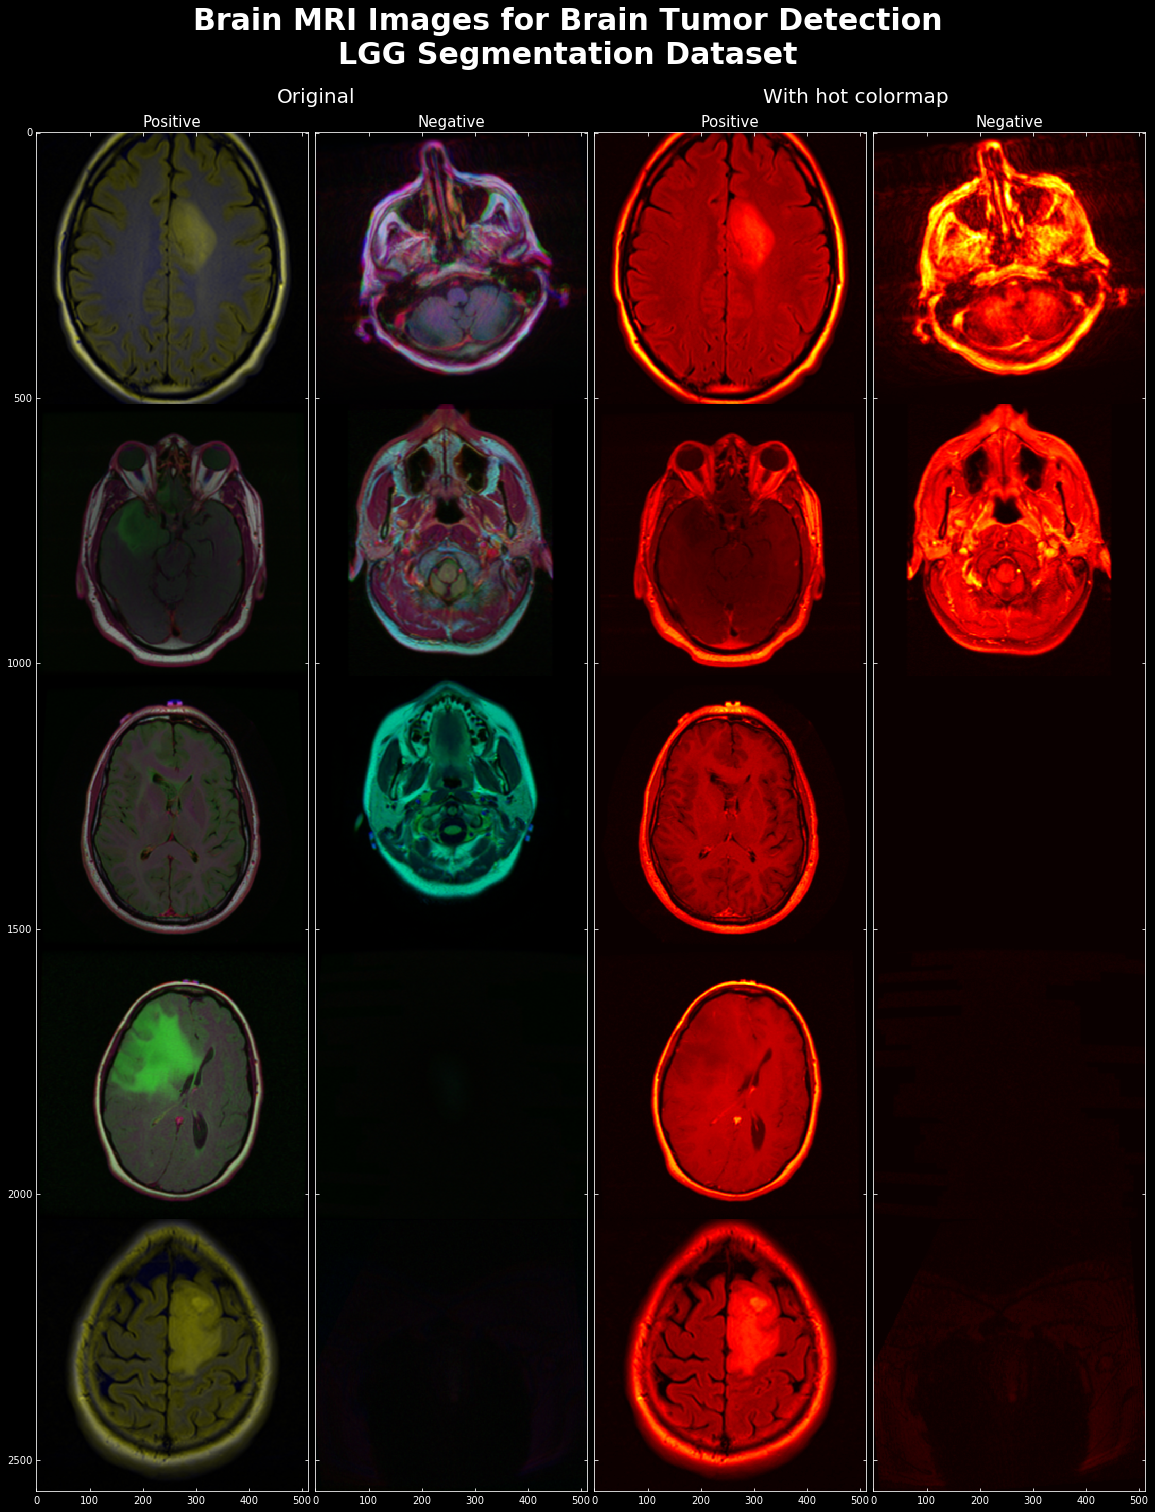

In [8]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Samples of images and masks with a positive diagnosis

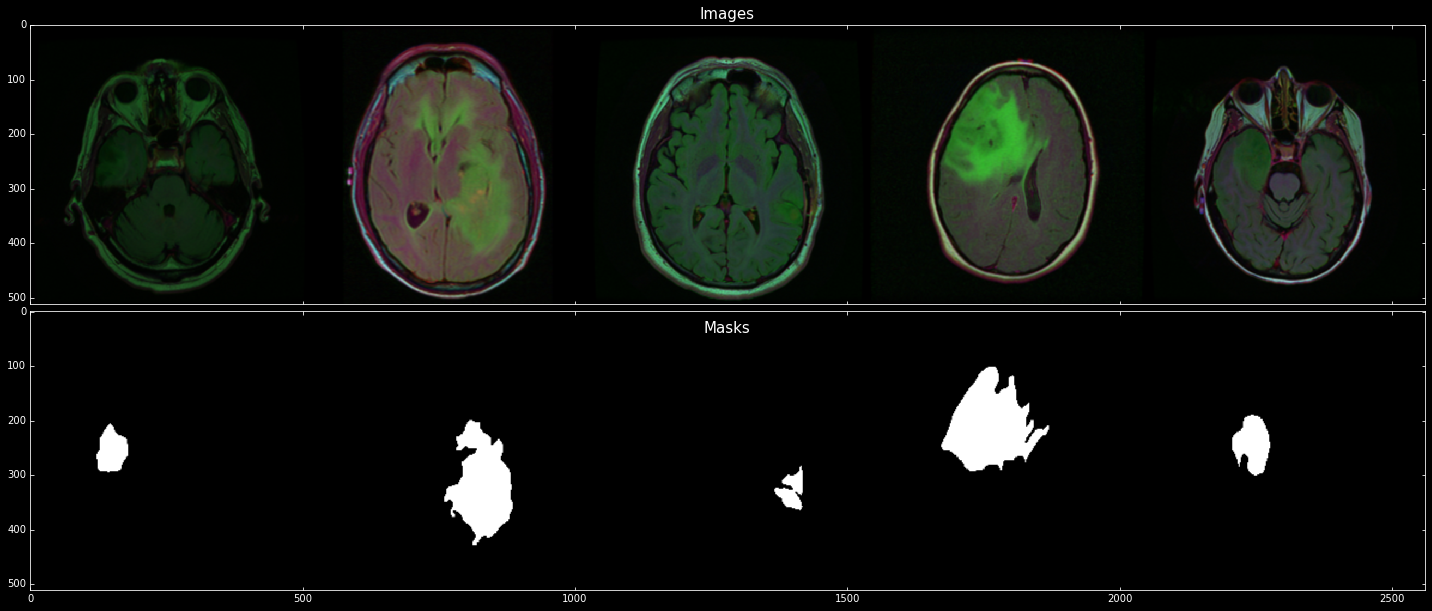

In [9]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

# DataGenerator and Data Augmentation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

DataGenerator

In [12]:
import functools

def apply_median_blur(img, **kwargs):
    ksize = kwargs.get('ksize', 3)
    return cv2.medianBlur(img, ksize=ksize)

def apply_gaussian_blur(img, **kwargs):
    ksize = kwargs.get('ksize', (3, 3))
    return cv2.GaussianBlur(img, ksize=ksize, sigmaX=0)

In [13]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        # Apply median filter preprocessing
        image = cv2.medianBlur(image, ksize=3)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
        # unnormilize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)       

transforms

In [14]:
PATCH_SIZE = 128

strong_transforms = A.Compose([
    A.RandomResizedCrop(width=PATCH_SIZE, height=PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit=3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5),
        A.IAAPiecewiseAffine(p=0.5)
    ], p=0.8),

    A.Normalize(p=1.0),
    # https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensor(),
])

# Define the transforms including the median filter
transforms = A.Compose([
    A.Resize(width=PATCH_SIZE, height=PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Apply median filter to the image
    A.Lambda(image=functools.partial(apply_median_blur, ksize=3)),

    # Apply Gaussian blur to the image
    A.Lambda(image=functools.partial(apply_gaussian_blur, ksize=(3, 3))),
    
    A.Normalize(p=1.0),
    ToTensor(),
])

Split data on train val test

In [15]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [16]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

Augmentation Visualization

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


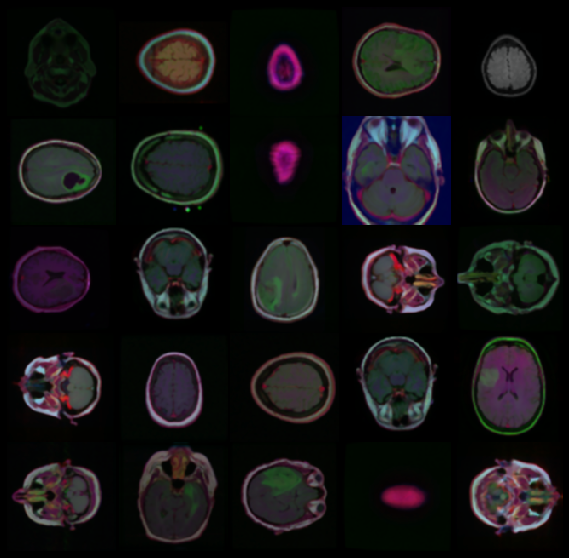

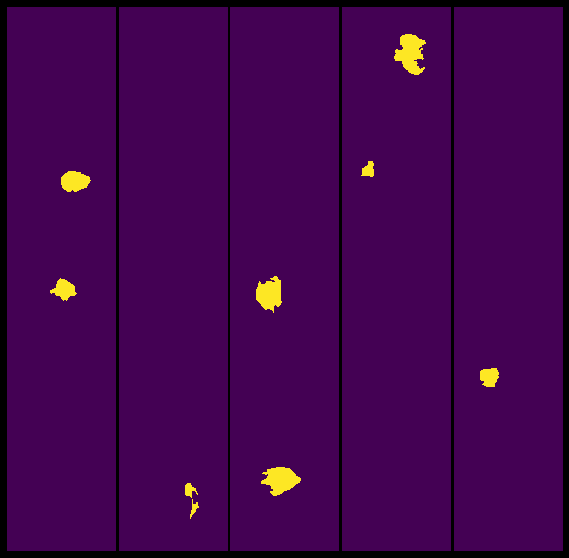

In [17]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
        
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

## UNet

<p> 
    <img src="https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="650" height="300">
</p>

In [18]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [20]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512) 
        self.conv_down5 = double_conv(512, 1024)        
        self.conv_down6 = double_conv(1024, 1024) 

        self.avgpool = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up5 = double_conv(1024 + 1024, 512)
        self.conv_up4 = double_conv(512 + 512, 256)
        self.conv_up3 = double_conv(256 + 256, 128)
        self.conv_up2 = double_conv(128 + 128, 64)
        self.conv_up1 = double_conv(64 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)

        
    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.avgpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.avgpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.avgpool(conv3)
        conv4 = self.conv_down4(x)
        x = self.avgpool(conv4)
        conv5 = self.conv_down5(x)
        x = self.avgpool(conv5)
        x = self.conv_down6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv5], dim=1)
        x = self.conv_up5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.conv_up4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv_up1(x)
        out = self.last_conv(x)
        out = torch.sigmoid(out)
        
        return out

In [21]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


## Feature Pyramid Network + UNet

In [22]:
import torch.nn as nn

class ConvReLUBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),  # Change nn.ELU to nn.LeakyReLU
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x


class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReLUBlock(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReLUBlock(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)


In [23]:

class FPN(nn.Module):

    def __init__(self, n_classes=1, 
                 pyramid_channels=256, 
                 segmentation_channels=256):
        super().__init__()
         
        # Bottom-up layers
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        
        self.conv_down5 = double_conv(512, 1024)   
        self.avgpool = nn.AvgPool2d(2)  # Average pooling instead of Max pooling
        
        # Top layer
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        # Segmentation block layers
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])
        
        # Last layer
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True) 
        
        return upsample(x) + y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)
        
    def forward(self, x):
        
        # Bottom-up
        c1 = self.avgpool(self.conv_down1(x))
        c2 = self.avgpool(self.conv_down2(c1))
        c3 = self.avgpool(self.conv_down3(c2))
        c4 = self.avgpool(self.conv_down4(c3))
        c5 = self.avgpool(self.conv_down5(c4)) 
        
        # Top-down
        p5 = self.toplayer(c5) 
        p4 = self.upsample_add(p5, self.latlayer1(c4)) 
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2)) 
        
        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        # Segmentation
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w)
        
        out = torch.sigmoid(out)
        return out

In [24]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


## Unet with ResNeXt50 backbone.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnext50_32x4d

class ConvLeakyRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.conv_leakyrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

    def forward(self, x):
        x = self.conv_leakyrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvLeakyRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvLeakyRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [19]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=False)
        self.base_model.load_state_dict(torch.load("/kaggle/input/resnext50/resnext50_32x4d-7cdf4587.pth"))
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvLeakyRelu(256, 128, 3, 1)
        self.last_conv1 = ConvLeakyRelu(128, 64, 3, 1)
        self.last_conv2 = nn.Conv2d(64, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = self.last_conv2(out)
        out = torch.sigmoid(out)
        
        return out

In [20]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [111]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1, 3, 256, 256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


# Segmentation Quality Metric

In [21]:
import torch
import torch.nn as nn

def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)

def iou_score(inputs, target):
    intersection = (inputs * target).sum()
    union = (inputs + target).sum() - intersection
    smooth = 1e-6
    iou = (intersection + smooth) / (union + smooth)
    return iou

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Testing the loss functions
print("Dice Coefficient Loss:", dice_coef_loss(torch.tensor([0.7, 1., 1.]), 
                                              torch.tensor([1.,1.,1.])))
print("IoU Score:", iou_score(torch.tensor([0., 0.9]), 
                              torch.tensor([0., 1.])))
print("Combined Loss (BCE + Dice):", bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
                                                   torch.tensor([1.,1.,1.])))

Dice Coefficient Loss: tensor(0.0448)
IoU Score: tensor(0.9000)
Combined Loss (BCE + Dice): tensor(0.1637)


# Train Models

In [22]:
import torch
import numpy as np

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_dice = []
        train_iou = []
        
        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice_val = dice_coef_metric(out_cut, target.data.cpu().numpy())
            train_iou_val = iou_score(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_dice.append(train_dice_val)
            train_iou.append(train_iou_val)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        val_mean_dice = compute_dice(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_dice).mean())
        val_history.append(val_mean_dice)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_dice).mean(),
              "\nMean IoU on train:", np.array(train_iou).mean(),
              "\nMean DICE on validation:", val_mean_dice)
        
    return loss_history, train_history, val_history


In [23]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():
        for i_step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [24]:
def compute_dice(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():
        for i_step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [25]:
# Optimizers
#unet_optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)
#fpn_optimizer = torch.optim.Adam(fpn.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

# lr_scheduler
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [26]:
%%time
num_ep = 50                                                                                                  
# Train UNet
#unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, num_ep) 

# Train FPN
#fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, num_ep)#

# Train ResNeXt50
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

ResNeXt50
Epoch [0]
Mean loss on train: 0.626380434580918 
Mean DICE on train: 0.44437264718073605 
Mean IoU on train: 0.33981155304871347 
Mean DICE on validation: 0.8037378730968054
Epoch [1]
Mean loss on train: 0.2846073601394892 
Mean DICE on train: 0.7544665106414558 
Mean IoU on train: 0.6159288831917623 
Mean DICE on validation: 0.781116186566575
Epoch [2]
Mean loss on train: 0.2356837258256715 
Mean DICE on train: 0.7966960071341231 
Mean IoU on train: 0.6692647831918354 
Mean DICE on validation: 0.7947561750916926
Epoch [3]
Mean loss on train: 0.22438266866936765 
Mean DICE on train: 0.8032430541638953 
Mean IoU on train: 0.6790300296907752 
Mean DICE on validation: 0.8986768438813365
Epoch [4]
Mean loss on train: 0.19953312063268547 
Mean DICE on train: 0.823074722650697 
Mean IoU on train: 0.7072481416168144 
Mean DICE on validation: 0.8881796340029722
Epoch [5]
Mean loss on train: 0.20842867306080357 
Mean DICE on train: 0.8203953184702836 
Mean IoU on train: 0.701014903314

## Train history 

In [127]:
import matplotlib.pyplot as plt
import cv2
import time

def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs, train_iou_history, val_iou_history, train_tversky_history):
    
    x = np.arange(num_epochs)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].plot(x, train_history, label='train dice', lw=3, c="springgreen")
    axs[0, 0].plot(x, val_history, label='validation dice', lw=3, c="deeppink")
    axs[0, 0].set_title(f"{model_name} - Dice", fontsize=15)
    axs[0, 0].legend(fontsize=12)
    axs[0, 0].set_xlabel("Epoch", fontsize=12)
    axs[0, 0].set_ylabel("DICE", fontsize=12)

    axs[0, 1].plot(x, train_iou_history, label='train IoU', lw=3, c="darkorange")
    axs[0, 1].plot(x, val_iou_history, label='validation IoU', lw=3, c="royalblue")
    axs[0, 1].set_title(f"{model_name} - IoU", fontsize=15)
    axs[0, 1].legend(fontsize=12)
    axs[0, 1].set_xlabel("Epoch", fontsize=12)
    axs[0, 1].set_ylabel("IoU", fontsize=12)

    axs[1, 0].plot(x, train_tversky_history, label='train Tversky', lw=3, c="gold")
    axs[1, 0].set_title(f"{model_name} - Tversky", fontsize=15)
    axs[1, 0].legend(fontsize=12)
    axs[1, 0].set_xlabel("Epoch", fontsize=12)
    axs[1, 0].set_ylabel("Tversky", fontsize=12)

    plt.tight_layout()
    plt.show()

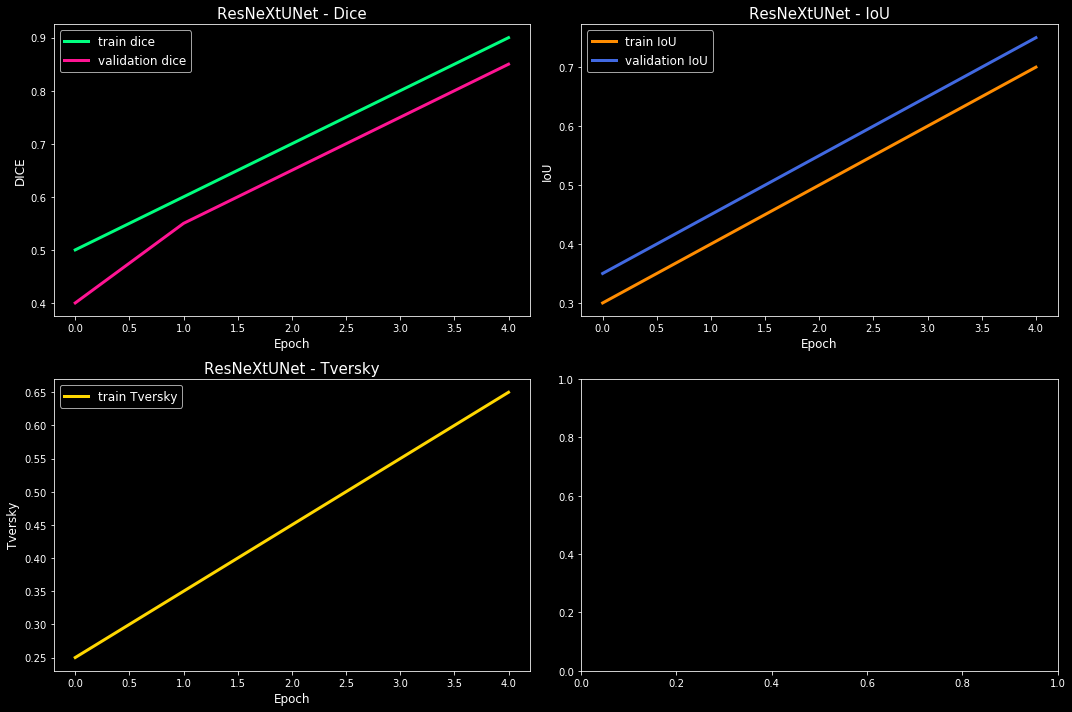

In [128]:
# Test
plot_model_history("ResNeXtUNet",
                   [0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.4, 0.55, 0.65, 0.75, 0.85],
                   5,
                   [0.3, 0.4, 0.5, 0.6, 0.7],
                   [0.35, 0.45, 0.55, 0.65, 0.75],
                   [0.25, 0.35, 0.45, 0.55, 0.65])

# Test Prediction

### Test IoU

In [27]:
#test_iou = compute_iou(unet, test_dataloader)
#print(f"""Vanilla UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

#test_iou = compute_dice(fpn, test_dataloader)
#print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

test_iou = compute_dice(rx50, test_dataloader)
print(f"""ResNext50\nMean Dice of the test images - {np.around(test_iou, 2)*100}%""")

ResNext50
Mean Dice of the test images - 93.0%


### random test sample

# **Genomic Types and Shape Features**

In [28]:
import pandas as pd
import cv2
import numpy as np
from skimage.measure import regionprops
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

def eccentricity(mask):
    label_image = np.uint8(mask / 255)
    labeled_mask = label_image.astype(np.uint8)
    regions = regionprops(labeled_mask)
    if len(regions) == 0:
        return np.nan
    return regions[0].eccentricity

def bounding_ellipsoid_volume_ratio(mask):
    label_image = np.uint8(mask / 255)
    labeled_mask = label_image.astype(np.uint8)
    regions = regionprops(labeled_mask)
    if len(regions) == 0:
        return np.nan
    equivalent_diameter = regions[0].equivalent_diameter
    ellipsoid_volume = (4/3) * np.pi * (equivalent_diameter / 2)**3
    bounding_box_volume = np.prod(mask.shape)  # Volume of a bounding box = width * height * depth
    volume_ratio = bounding_box_volume / ellipsoid_volume
    return volume_ratio

def margin_fluctuation(mask):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate contour areas
    contour_areas = [cv2.contourArea(contour) for contour in contours]
    
    # Filter out zero area contours
    contour_areas = [area for area in contour_areas if area > 0]
    
    # Calculate margin fluctuation
    if len(contour_areas) > 1:
        max_area = max(contour_areas)
        min_area = min(contour_areas)
        margin_fluctuation = max_area / min_area
    else:
        margin_fluctuation = np.nan
    return margin_fluctuation


def angular_standard_deviation(mask):
    y, x = np.where(mask == 255)
    if len(x) == 0 or len(y) == 0:
        return np.nan
    
    x_centered = x - np.mean(x)
    y_centered = y - np.mean(y)
    
    # Calculate the Angular Standard Deviation
    angle = np.arctan2(y_centered, x_centered)
    angle_std = np.std(angle)
    
    return angle_std

In [29]:
def solidity(mask):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if contours are found
    if len(contours) == 0:
        return np.nan
    
    # Calculate contour area
    contour_area = cv2.contourArea(contours[0])
    
    # Calculate convex hull and its area
    hull = cv2.convexHull(contours[0])
    hull_area = cv2.contourArea(hull)
    
    # Check if hull area is zero to avoid ZeroDivisionError
    if hull_area == 0:
        return np.nan
    
    # Calculate solidity
    solidity_val = contour_area / hull_area
    
    return solidity_val

def extent(mask):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if contours are found
    if len(contours) == 0:
        return np.nan
    
    # Calculate contour area
    contour_area = cv2.contourArea(contours[0])
    
    # Calculate bounding box area
    x, y, w, h = cv2.boundingRect(contours[0])
    bounding_box_area = w * h
    
    # Calculate extent
    extent_val = contour_area / bounding_box_area
    
    return extent_val


def equivalent_diameter(mask):
    label_image = np.uint8(mask / 255)
    labeled_mask = label_image.astype(np.uint8)
    regions = regionprops(labeled_mask)
    if len(regions) == 0:
        return np.nan
    return regions[0].equivalent_diameter

def perimeter(mask):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if contours are found
    if len(contours) == 0:
        return np.nan
    
    # Calculate perimeter
    perimeter_val = cv2.arcLength(contours[0], True)
    
    return perimeter_val

def convexity_defects(mask):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if contours are found
    if len(contours) == 0:
        return np.nan
    
    # Convex Hull
    hull = cv2.convexHull(contours[0], returnPoints=False)
    
    # Calculate convexity defects
    defects = cv2.convexityDefects(contours[0], hull)
    
    # Check if defects are found
    if defects is None:
        return 0
    
    # Calculate the number of convexity defects
    num_defects = defects.shape[0]
    
    return num_defects


def aspect_ratio(mask):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if contours are found
    if len(contours) == 0:
        return np.nan
    
    # Calculate bounding rectangle
    x, y, w, h = cv2.boundingRect(contours[0])
    
    # Calculate aspect ratio
    aspect_ratio_val = float(w) / h
    
    return aspect_ratio_val

In [30]:
# Texture feature calculation functions

def texture_features(image, mask):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
    glcm = greycomatrix(masked_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    return contrast, correlation, energy, homogeneity

In [31]:
data_df = pd.read_csv("/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv")

data_map = []

for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        # Iterate over each file in the subdirectory
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            # Extract patient ID from filename and remove additional information
            patient_id = '_'.join(filename.split('_')[:3])
            # Get histological_type from data_df using patient ID
            histological_type = data_df[data_df['Patient'] == patient_id]['histological_type'].values
            if len(histological_type) > 0 and histological_type[0] == 1:
                # Get RNASeqCluster, CNCluster, RPPACluster, and COCCluster from data_df using patient ID
                cluster_row = data_df[data_df['Patient'] == patient_id]
                rna_seq_cluster = cluster_row.iloc[0]['RNASeqCluster'] if not cluster_row.empty else "Unknown"
                cnc_cluster = cluster_row.iloc[0]['CNCluster'] if not cluster_row.empty else "Unknown"
                rppa_cluster = cluster_row.iloc[0]['RPPACluster'] if not cluster_row.empty else "Unknown"
                coc_cluster = cluster_row.iloc[0]['COCCluster'] if not cluster_row.empty else "Unknown"
                methy_cluster = cluster_row.iloc[0]['MethylationCluster'] if not cluster_row.empty else "Unknown"
                mir_cluster = cluster_row.iloc[0]['miRNACluster'] if not cluster_row.empty else "Unknown"
                onco_cluster = cluster_row.iloc[0]['OncosignCluster'] if not cluster_row.empty else "Unknown"
                # Append patient ID, image path, and RNASeqCluster together
                data_map.append([patient_id, image_path, histological_type[0], rna_seq_cluster, cnc_cluster, rppa_cluster, coc_cluster, methy_cluster, mir_cluster, onco_cluster])
    except Exception as e:
        print(e)

# Creating DataFrame with patient_id, path, and RNASeqCluster
df = pd.DataFrame(data_map, columns=["patient_id", "path", "histological_type", "RNASeqCluster", "CNCluster", "RPPACluster", "COCCluster", "MethylationCluster", "miRNACluster", "OncosignCluster"])
df.head()

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


patient_id                                               path  \
0  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

   histological_type  RNASeqCluster  CNCluster  RPPACluster  COCCluster  \
0                1.0            2.0        2.0          1.0           2   
1                1.0            2.0        2.0          1.0           2   
2                1.0            2.0        2.0          1.0           2   
3                1.0            2.0        2.0          1.0           2   
4                1.0            2.0        2.0          1.0           2   

   MethylationCluster  miRNACluster  OncosignCluster  
0                 5.0             2              2.0  
1                 5.0             2              2.0  
2                 5.0             2              2.0  
3                 5.0             2              2.0  
4                 5.0             2              2.0

In [32]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values)
masks = sorted(df_masks["path"].values)

In [33]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs["patient_id"].values,
                   "image_path": imgs,
                   "mask_path": masks,
                   "histological_type": df_imgs["histological_type"].values,
                   "RNASeqCluster": df_imgs["RNASeqCluster"].values,
                   "CNCluster": df_imgs["CNCluster"].values,
                   "RPPACluster": df_imgs["RPPACluster"].values,
                   "COCCluster": df_imgs["COCCluster"].values,
                   "MethylationCluster": df_imgs["MethylationCluster"].values,
                   "miRNACluster": df_imgs["miRNACluster"].values,
                   "OncosignCluster": df_imgs["OncosignCluster"].values,
                  })

# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else:
        return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df.head()

patient                                         image_path  \
0  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  histological_type  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...                1.0   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...                1.0   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...                1.0   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...                1.0   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...                1.0   

   RNASeqCluster  CNCluster  RPPACluster  COCCluster  MethylationCluster  \
0            2.0        2.0          1.0           2                 5.0   
1            2.0        2.0          1.0           2                 5.0   
2            2.0        2.0          1.0           2                 5.0   
3            2.0        2.0          1.0           2                 5.0   
4            2.0        2.0          1.0           2                 5.0   

   miRNACluster  OncosignCluster  diagnosis  
0             2              2.0          0  
1             2              2.0          1  
2             2              2.0          1  
3             2              2.0          1  
4             2              2.0          1

In [63]:
df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df.head()
# Add predicted masks to the dataframe
predicted_masks = []
for index, row in df.iterrows():
    # Load image and perform prediction
    image = cv2.imread(row["image_path"])
    pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
    pred = rx50(pred.to(device))
    pred = pred.detach().cpu().numpy()[0,0,:,:]

    # Apply threshold to the predicted mask
    pred_mask = np.copy(pred)
    pred_mask[np.nonzero(pred_mask < 0.3)] = 0.0
    pred_mask[np.nonzero(pred_mask >= 0.3)] = 255.0
    pred_mask = pred_mask.astype("uint8")
    
    # Store predicted mask
    predicted_masks.append(pred_mask)

In [64]:
df["predicted_mask"] = predicted_masks

In [48]:
print("Total Patients after diagnosis condition:", len(df[df['diagnosis'] == 1]["patient"].unique()))
print("Total Images after diagnosis condition:", len(df[df['diagnosis'] == 1]))
print("Total Masks after diagnosis condition:", len(predicted_masks))

Total Patients after diagnosis condition: 29
Total Images after diagnosis condition: 348
Total Masks after diagnosis condition: 1032


In [65]:
# Initialize lists to store results
angular_std_list = []
bounding_ellipsoid_volume_ratio_list = []
margin_fluctuation_list = []
RNASeqCluster_list = []
ecce_list = []
solidity_list = []
extent_list = []
equivalent_diameter_list = []
perimeter_list = []
convexity_defects_list = []
aspect_ratio_list = []
methyCluster_list = []
mirCluster_list = []
oncoCluster_list = []
cncCluster_list = []
rppaCluster_list = []
cocCluster_list = []
predicted_mask_paths_list = []
patient_id_list = []
diagnosis_list = []
# Texture feature lists
contrast_list = []
correlation_list = []
energy_list = []
homogeneity_list = []

In [66]:
import pandas as pd
import cv2
import numpy as np
from skimage.measure import regionprops
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import glob
import os
import torch

for index, row in df.iterrows():  # Iterate over the entire dataframe, including those without a diagnosis
    if row['diagnosis'] == 1:  # Only perform calculations for images with a diagnosis
        # Calculate eccentricity, bounding ellipsoid volume ratio, margin fluctuation, and angular standard deviation
        ecc = eccentricity(row['predicted_mask'])
        ang_std = angular_standard_deviation(row['predicted_mask'])
        bounding_ellipsoid_volume_ratio_val = bounding_ellipsoid_volume_ratio(row['predicted_mask'])
        margin_fluctuation_val = margin_fluctuation(row['predicted_mask'])
        solid = solidity(row['predicted_mask'])
        ex = extent(row['predicted_mask'])
        eq = equivalent_diameter(row['predicted_mask'])
        per = perimeter(row['predicted_mask'])
        conv = convexity_defects(row['predicted_mask'])
        asp = aspect_ratio(row['predicted_mask'])
        contrast, correlation, energy, homogeneity = texture_features(cv2.imread(row["image_path"]), row['predicted_mask'])

        # Store results
        ecce_list.append(ecc)
        angular_std_list.append(ang_std)
        bounding_ellipsoid_volume_ratio_list.append(bounding_ellipsoid_volume_ratio_val)
        margin_fluctuation_list.append(margin_fluctuation_val)
        solidity_list.append(solid)
        extent_list.append(ex)
        equivalent_diameter_list.append(eq)
        perimeter_list.append(per)
        convexity_defects_list.append(conv)
        aspect_ratio_list.append(asp)
        
        # Store texture features
        contrast_list.append(contrast)
        correlation_list.append(correlation)
        energy_list.append(energy)
        homogeneity_list.append(homogeneity)

        # Store genomic subtype information
        RNASeqCluster_list.append(row["RNASeqCluster"])
        cncCluster_list.append(row["CNCluster"])
        rppaCluster_list.append(row["RPPACluster"])
        cocCluster_list.append(row["COCCluster"])
        methyCluster_list.append(row["MethylationCluster"])
        mirCluster_list.append(row["miRNACluster"])
        oncoCluster_list.append(row["OncosignCluster"])
        
        # Store patient ID
    patient_id_list.append(row["patient"])
    
    # Store diagnosis
    diagnosis_list.append(row["diagnosis"])

In [52]:
data = {
    "Eccentricity": ecce_list,
    "Angular_Std": angular_std_list,
    "Bounding_Ellipsoid_Volume_Ratio": bounding_ellipsoid_volume_ratio_list,
    "Solidity": solidity_list,
    "Extent": extent_list,
    "Equivalent Diameter": equivalent_diameter_list,
    "Perimeter": perimeter_list,
    "Convexity Defects": convexity_defects_list,
    "Aspect Ratio": aspect_ratio_list,
    "contrast": contrast_list,
    "correlation": correlation_list,
    "energy": energy_list,
    "homogeneity": homogeneity_list,
    "Margin_Fluctuation": margin_fluctuation_list,
    "RNASeqCluster": RNASeqCluster_list,
    "CNCluster": cncCluster_list,
    "RPPACluster": rppaCluster_list,
    "COCCluster": cocCluster_list,
    "MethylationCluster": methyCluster_list,
    "miRNACluster": mirCluster_list,
    "OncosignCluster": oncoCluster_list
}

df = pd.DataFrame(data)

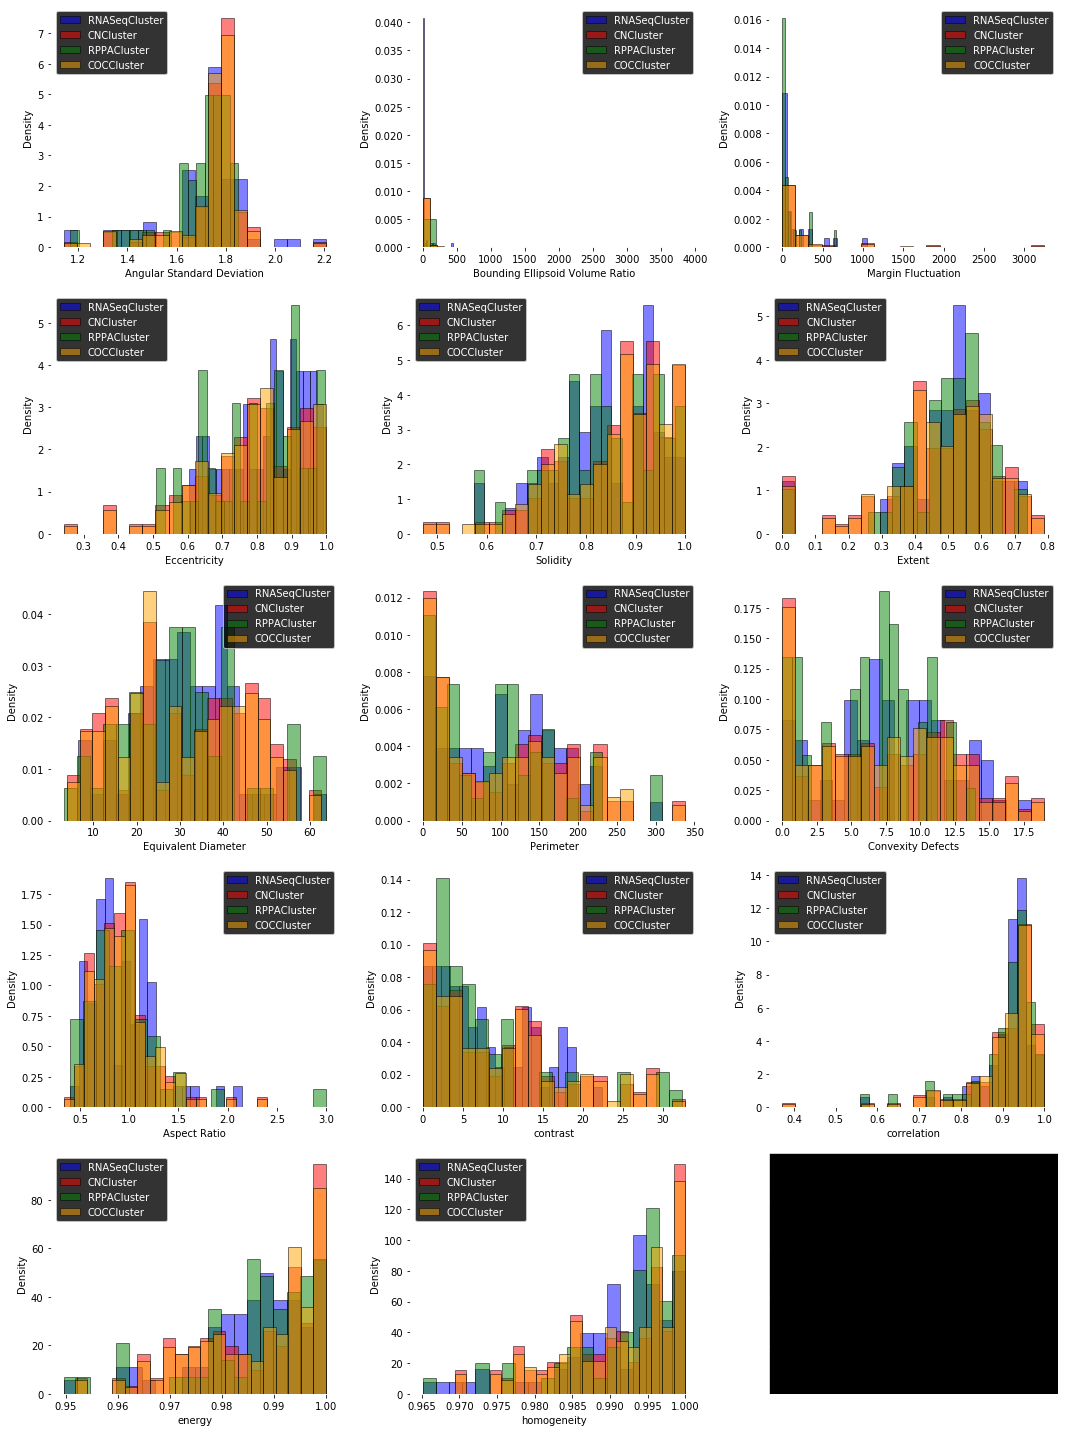

RNASeqCluster
2.0    178
1.0     72
4.0     27
Name: RNASeqCluster, dtype: int64


CNCluster
1.0    199
2.0    127
3.0     11
Name: CNCluster, dtype: int64


RPPACluster
1.0    104
3.0     87
2.0     57
4.0     11
Name: RPPACluster, dtype: int64


COCCluster
1    186
2    151
Name: COCCluster, dtype: int64




In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the lists are already defined
results_df = pd.DataFrame({
    "Angular Standard Deviation": angular_std_list,
    "Bounding Ellipsoid Volume Ratio": bounding_ellipsoid_volume_ratio_list,
    "Margin Fluctuation": margin_fluctuation_list,
    "Eccentricity": ecce_list,
    "Solidity": solidity_list,
    "Extent": extent_list,
    "Equivalent Diameter": equivalent_diameter_list,
    "Perimeter": perimeter_list,
    "Convexity Defects": convexity_defects_list,
    "Aspect Ratio": aspect_ratio_list,
    "contrast": contrast_list,
    "correlation": correlation_list,
    "energy": energy_list,
    "homogeneity": homogeneity_list,
    "RNASeqCluster": RNASeqCluster_list,
    "CNCluster": cncCluster_list,
    "RPPACluster": rppaCluster_list,
    "COCCluster": cocCluster_list
})

# Display features distribution
fig, axes = plt.subplots(5, 3, figsize=(15, 20), facecolor='white')
axes = axes.flatten()

for i, col in enumerate(results_df.columns[:-4]):
    ax = axes[i]
    ax.set_facecolor('white')
    ax.hist(results_df[col][results_df["RNASeqCluster"] == 1], bins=20, color='blue', alpha=0.5, label='RNASeqCluster', edgecolor='black', density=True)
    ax.hist(results_df[col][results_df["CNCluster"] == 2], bins=20, color='red', alpha=0.5, label='CNCluster', edgecolor='black', density=True)
    ax.hist(results_df[col][results_df["RPPACluster"] == 2], bins=20, color='green', alpha=0.5, label='RPPACluster', edgecolor='black', density=True)
    ax.hist(results_df[col][results_df["COCCluster"] == 2], bins=20, color='orange', alpha=0.5, label='COCCluster', edgecolor='black', density=True)
    ax.set_xlabel(col, color='black')
    ax.set_ylabel('Density', color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.legend()

plt.tight_layout()
plt.show()

# Display cluster distribution
cluster_names = ["RNASeqCluster", "CNCluster", "RPPACluster", "COCCluster"]
for name in cluster_names:
    print(name)
    print(results_df[name].value_counts())
    print("\n")


In [53]:
# Viewing results
for patient_id, ecc, ang_std, bounding_ellipsoid_volume_ratio_val, margin_fluctuation_val, solid, ex, eq, per, conv, asp, RNASeqCluster, CNCluster, RPPACluster, COCCluster, MethylationCluster, miRNACluster, OncosignCluster in zip(patient_id_list, ecce_list, angular_std_list, bounding_ellipsoid_volume_ratio_list, margin_fluctuation_list, solidity_list, extent_list, equivalent_diameter_list, perimeter_list, convexity_defects_list, aspect_ratio_list, RNASeqCluster_list, cncCluster_list, rppaCluster_list, cocCluster_list, methyCluster_list, mirCluster_list, oncoCluster_list):
    print("Patient ID:", patient_id)
    print("Eccentricity:", ecc)
    print("Angular Standard Deviation:", ang_std)
    print("RNASeqCluster:", RNASeqCluster)
    print("CNCluster:", CNCluster)
    print("RPPACluster:", RPPACluster)
    print("COCCluster:", COCCluster)
    print("MethylationCluster:", MethylationCluster)
    print("miRNACluster:", miRNACluster)
    print("OncosignCluster:", OncosignCluster)
    print("Bounding Ellipsoid Volume Ratio:", bounding_ellipsoid_volume_ratio_val)
    print("Margin Fluctuation:", margin_fluctuation_val)
    print("Solidity:", solid)
    print("Extent:", ex)
    print("Equivalent Diameter:", eq)
    print("Perimeter:", per)
    print("Convexity Defects:", conv)
    print("Aspect Ratio:", asp)
    print("Contrast:", contrast)
    print("Correlation:", correlation)
    print("Energy:", energy)
    print("Homogeneity:", homogeneity)

Patient ID: TCGA_FG_A4MT
Eccentricity: 0.9642704623587474
Angular Standard Deviation: 1.9286341599936723
RNASeqCluster: 1.0
CNCluster: 1.0
RPPACluster: 2.0
COCCluster: 1
MethylationCluster: 5.0
miRNACluster: 2
OncosignCluster: 2.0
Bounding Ellipsoid Volume Ratio: 439.4381470934737
Margin Fluctuation: 3.875
Solidity: 0.8157894736842105
Extent: 0.3875
Equivalent Diameter: 6.579524642479541
Perimeter: 19.071067571640015
Convexity Defects: 2
Aspect Ratio: 1.6
Contrast: 0.8598958333333331
Correlation: 0.7543634177971785
Energy: 0.9982078782104884
Homogeneity: 0.9990263136623103
Patient ID: TCGA_FG_A4MT
Eccentricity: 0.5943348372417127
Angular Standard Deviation: 1.8403317305518643
RNASeqCluster: 1.0
CNCluster: 1.0
RPPACluster: 2.0
COCCluster: 1
MethylationCluster: 5.0
miRNACluster: 2
OncosignCluster: 2.0
Bounding Ellipsoid Volume Ratio: 7.886669028428108
Margin Fluctuation: nan
Solidity: 0.8471698113207548
Extent: 0.5570719602977667
Equivalent Diameter: 25.13019725725687
Perimeter: 106.0832

P-values from Fisher's exact test:
Feature: Eccentricity, Subtype: RNASeqCluster, P-value: 0.501163658993551
Feature: Eccentricity, Subtype: CNCluster, P-value: 0.3598530108728867
Feature: Eccentricity, Subtype: RPPACluster, P-value: 0.03998081602059646
Feature: Eccentricity, Subtype: COCCluster, P-value: 0.2016257242385519
Feature: Eccentricity, Subtype: MethylationCluster, P-value: 0.03998081602059646
Feature: Eccentricity, Subtype: miRNACluster, P-value: 0.7018504079996051
Feature: Eccentricity, Subtype: OncosignCluster, P-value: 0.4636838448985172
Feature: Angular_Std, Subtype: RNASeqCluster, P-value: 0.1381735046826521
Feature: Angular_Std, Subtype: CNCluster, P-value: 0.06660739377745123
Feature: Angular_Std, Subtype: RPPACluster, P-value: 0.30752127223931075
Feature: Angular_Std, Subtype: COCCluster, P-value: 0.04809562505806937
Feature: Angular_Std, Subtype: MethylationCluster, P-value: 0.0058181769042841966
Feature: Angular_Std, Subtype: miRNACluster, P-value: 0.70185040799960

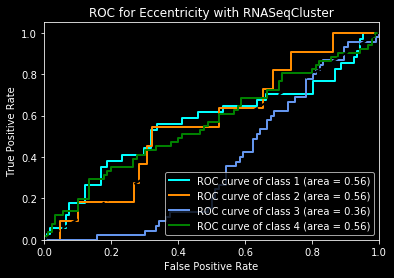

ROC AUC for RNASeqCluster class 1: 0.56
ROC AUC for RNASeqCluster class 2: 0.56
ROC AUC for RNASeqCluster class 3: 0.36
ROC AUC for RNASeqCluster class 4: 0.56


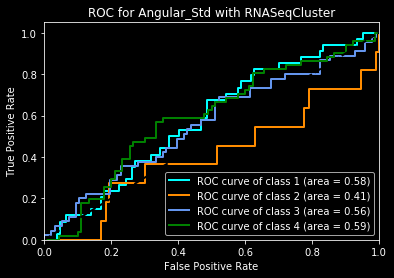

ROC AUC for RNASeqCluster class 1: 0.58
ROC AUC for RNASeqCluster class 2: 0.41
ROC AUC for RNASeqCluster class 3: 0.56
ROC AUC for RNASeqCluster class 4: 0.59


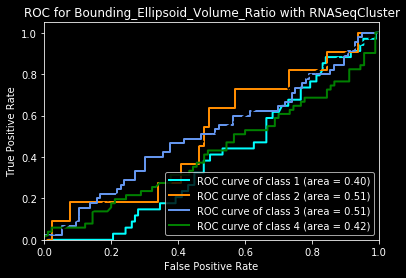

ROC AUC for RNASeqCluster class 1: 0.40
ROC AUC for RNASeqCluster class 2: 0.51
ROC AUC for RNASeqCluster class 3: 0.51
ROC AUC for RNASeqCluster class 4: 0.42


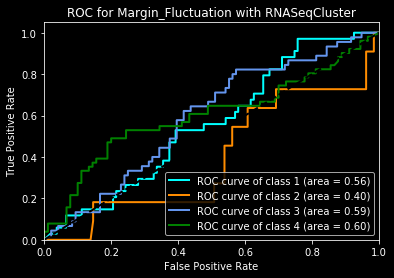

ROC AUC for RNASeqCluster class 1: 0.56
ROC AUC for RNASeqCluster class 2: 0.40
ROC AUC for RNASeqCluster class 3: 0.59
ROC AUC for RNASeqCluster class 4: 0.60


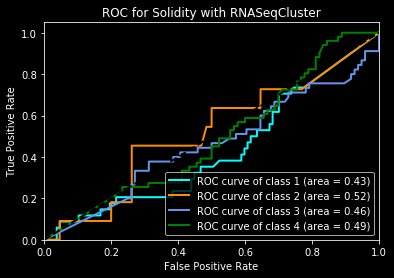

ROC AUC for RNASeqCluster class 1: 0.43
ROC AUC for RNASeqCluster class 2: 0.52
ROC AUC for RNASeqCluster class 3: 0.46
ROC AUC for RNASeqCluster class 4: 0.49


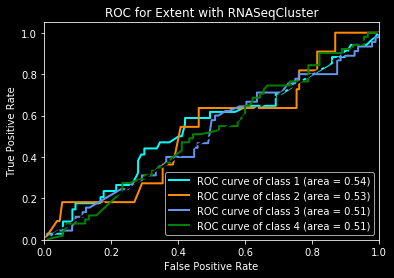

ROC AUC for RNASeqCluster class 1: 0.54
ROC AUC for RNASeqCluster class 2: 0.53
ROC AUC for RNASeqCluster class 3: 0.51
ROC AUC for RNASeqCluster class 4: 0.51


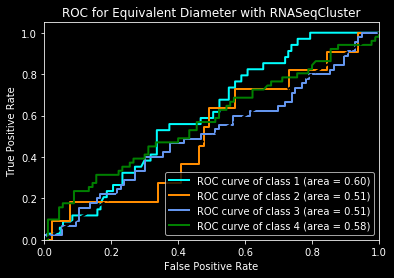

ROC AUC for RNASeqCluster class 1: 0.60
ROC AUC for RNASeqCluster class 2: 0.51
ROC AUC for RNASeqCluster class 3: 0.51
ROC AUC for RNASeqCluster class 4: 0.58


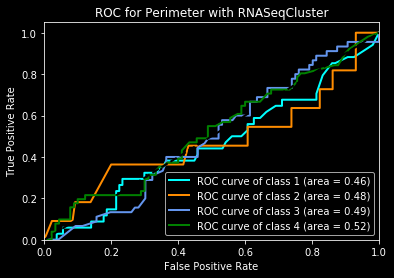

ROC AUC for RNASeqCluster class 1: 0.46
ROC AUC for RNASeqCluster class 2: 0.48
ROC AUC for RNASeqCluster class 3: 0.49
ROC AUC for RNASeqCluster class 4: 0.52


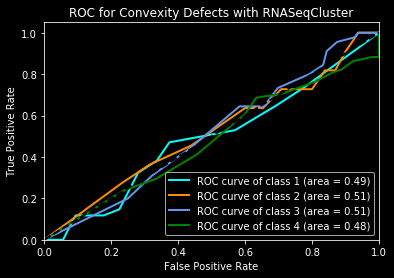

ROC AUC for RNASeqCluster class 1: 0.49
ROC AUC for RNASeqCluster class 2: 0.51
ROC AUC for RNASeqCluster class 3: 0.51
ROC AUC for RNASeqCluster class 4: 0.48


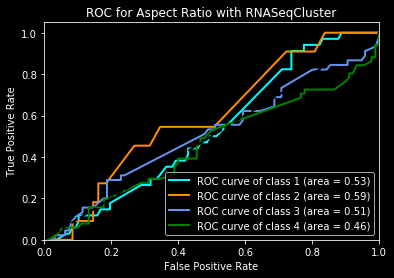

ROC AUC for RNASeqCluster class 1: 0.53
ROC AUC for RNASeqCluster class 2: 0.59
ROC AUC for RNASeqCluster class 3: 0.51
ROC AUC for RNASeqCluster class 4: 0.46


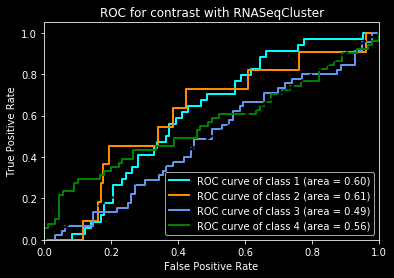

ROC AUC for RNASeqCluster class 1: 0.60
ROC AUC for RNASeqCluster class 2: 0.61
ROC AUC for RNASeqCluster class 3: 0.49
ROC AUC for RNASeqCluster class 4: 0.56


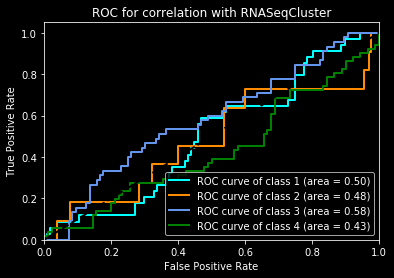

ROC AUC for RNASeqCluster class 1: 0.50
ROC AUC for RNASeqCluster class 2: 0.48
ROC AUC for RNASeqCluster class 3: 0.58
ROC AUC for RNASeqCluster class 4: 0.43


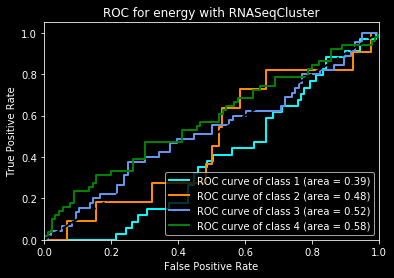

ROC AUC for RNASeqCluster class 1: 0.39
ROC AUC for RNASeqCluster class 2: 0.48
ROC AUC for RNASeqCluster class 3: 0.52
ROC AUC for RNASeqCluster class 4: 0.58


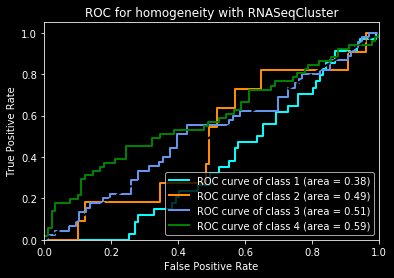

ROC AUC for RNASeqCluster class 1: 0.38
ROC AUC for RNASeqCluster class 2: 0.49
ROC AUC for RNASeqCluster class 3: 0.51
ROC AUC for RNASeqCluster class 4: 0.59


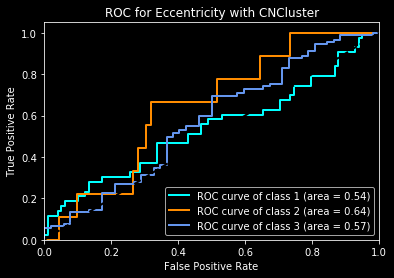

ROC AUC for CNCluster class 1: 0.54
ROC AUC for CNCluster class 2: 0.64
ROC AUC for CNCluster class 3: 0.57


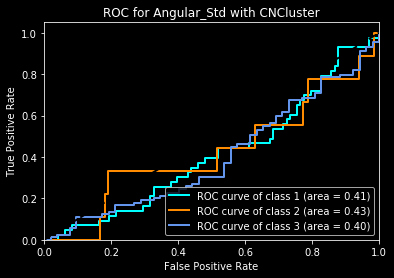

ROC AUC for CNCluster class 1: 0.41
ROC AUC for CNCluster class 2: 0.43
ROC AUC for CNCluster class 3: 0.40


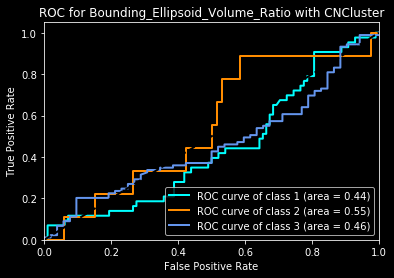

ROC AUC for CNCluster class 1: 0.44
ROC AUC for CNCluster class 2: 0.55
ROC AUC for CNCluster class 3: 0.46


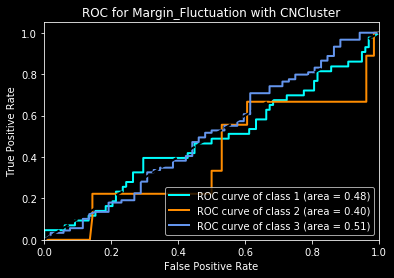

ROC AUC for CNCluster class 1: 0.48
ROC AUC for CNCluster class 2: 0.40
ROC AUC for CNCluster class 3: 0.51


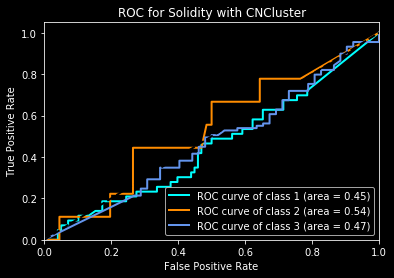

ROC AUC for CNCluster class 1: 0.45
ROC AUC for CNCluster class 2: 0.54
ROC AUC for CNCluster class 3: 0.47


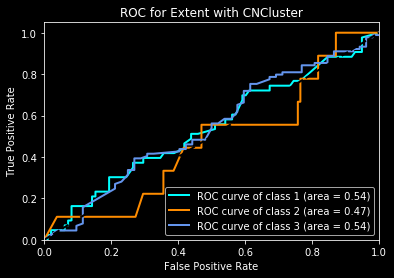

ROC AUC for CNCluster class 1: 0.54
ROC AUC for CNCluster class 2: 0.47
ROC AUC for CNCluster class 3: 0.54


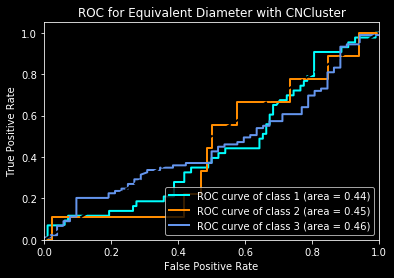

ROC AUC for CNCluster class 1: 0.44
ROC AUC for CNCluster class 2: 0.45
ROC AUC for CNCluster class 3: 0.46


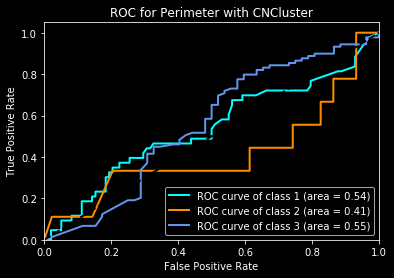

ROC AUC for CNCluster class 1: 0.54
ROC AUC for CNCluster class 2: 0.41
ROC AUC for CNCluster class 3: 0.55


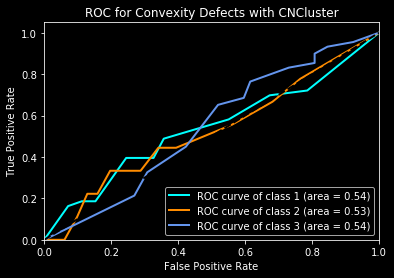

ROC AUC for CNCluster class 1: 0.54
ROC AUC for CNCluster class 2: 0.53
ROC AUC for CNCluster class 3: 0.54


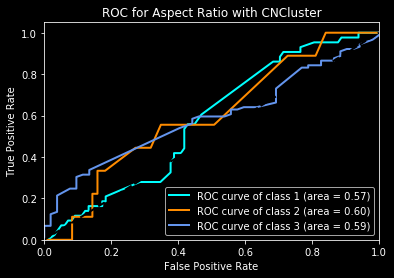

ROC AUC for CNCluster class 1: 0.57
ROC AUC for CNCluster class 2: 0.60
ROC AUC for CNCluster class 3: 0.59


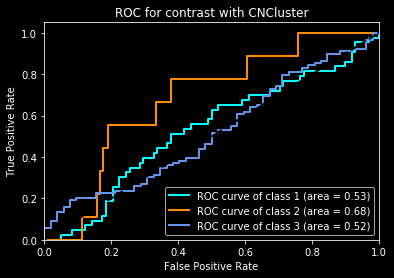

ROC AUC for CNCluster class 1: 0.53
ROC AUC for CNCluster class 2: 0.68
ROC AUC for CNCluster class 3: 0.52


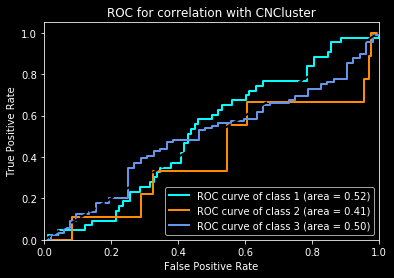

ROC AUC for CNCluster class 1: 0.52
ROC AUC for CNCluster class 2: 0.41
ROC AUC for CNCluster class 3: 0.50


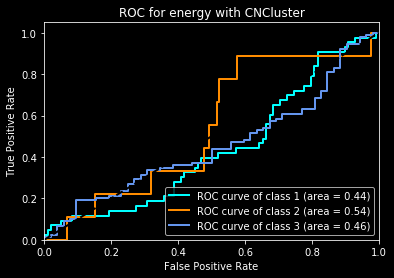

ROC AUC for CNCluster class 1: 0.44
ROC AUC for CNCluster class 2: 0.54
ROC AUC for CNCluster class 3: 0.46


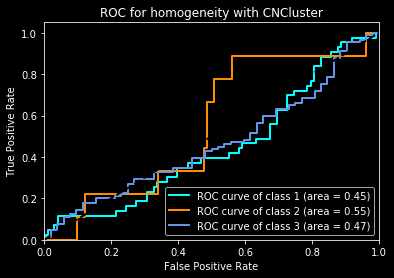

ROC AUC for CNCluster class 1: 0.45
ROC AUC for CNCluster class 2: 0.55
ROC AUC for CNCluster class 3: 0.47


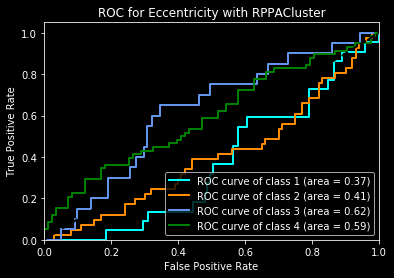

ROC AUC for RPPACluster class 1: 0.37
ROC AUC for RPPACluster class 2: 0.41
ROC AUC for RPPACluster class 3: 0.62
ROC AUC for RPPACluster class 4: 0.59


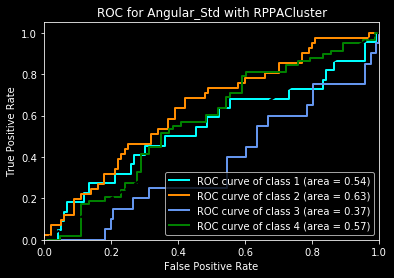

ROC AUC for RPPACluster class 1: 0.54
ROC AUC for RPPACluster class 2: 0.63
ROC AUC for RPPACluster class 3: 0.37
ROC AUC for RPPACluster class 4: 0.57


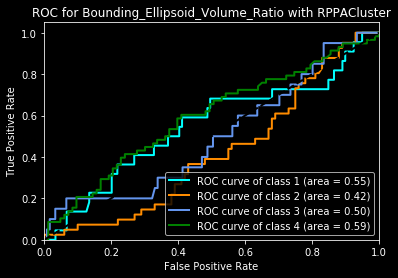

ROC AUC for RPPACluster class 1: 0.55
ROC AUC for RPPACluster class 2: 0.42
ROC AUC for RPPACluster class 3: 0.50
ROC AUC for RPPACluster class 4: 0.59


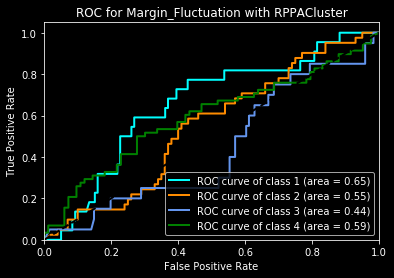

ROC AUC for RPPACluster class 1: 0.65
ROC AUC for RPPACluster class 2: 0.55
ROC AUC for RPPACluster class 3: 0.44
ROC AUC for RPPACluster class 4: 0.59


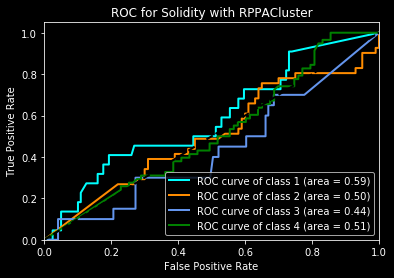

ROC AUC for RPPACluster class 1: 0.59
ROC AUC for RPPACluster class 2: 0.50
ROC AUC for RPPACluster class 3: 0.44
ROC AUC for RPPACluster class 4: 0.51


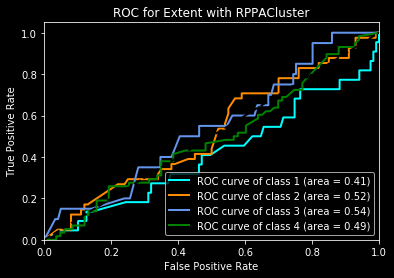

ROC AUC for RPPACluster class 1: 0.41
ROC AUC for RPPACluster class 2: 0.52
ROC AUC for RPPACluster class 3: 0.54
ROC AUC for RPPACluster class 4: 0.49


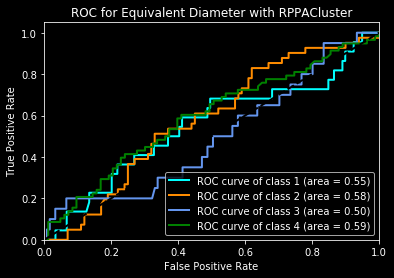

ROC AUC for RPPACluster class 1: 0.55
ROC AUC for RPPACluster class 2: 0.58
ROC AUC for RPPACluster class 3: 0.50
ROC AUC for RPPACluster class 4: 0.59


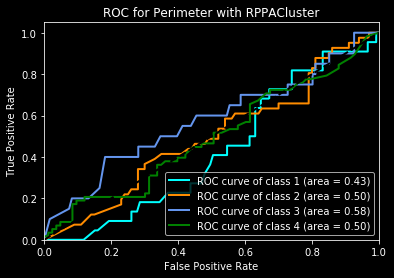

ROC AUC for RPPACluster class 1: 0.43
ROC AUC for RPPACluster class 2: 0.50
ROC AUC for RPPACluster class 3: 0.58
ROC AUC for RPPACluster class 4: 0.50


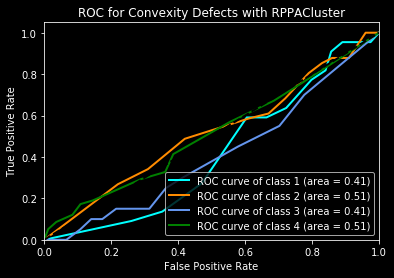

ROC AUC for RPPACluster class 1: 0.41
ROC AUC for RPPACluster class 2: 0.51
ROC AUC for RPPACluster class 3: 0.41
ROC AUC for RPPACluster class 4: 0.51


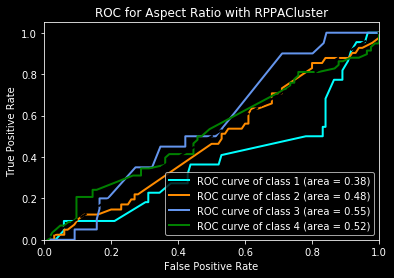

ROC AUC for RPPACluster class 1: 0.38
ROC AUC for RPPACluster class 2: 0.48
ROC AUC for RPPACluster class 3: 0.55
ROC AUC for RPPACluster class 4: 0.52


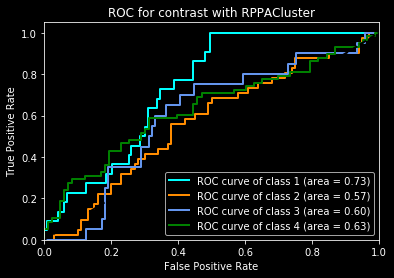

ROC AUC for RPPACluster class 1: 0.73
ROC AUC for RPPACluster class 2: 0.57
ROC AUC for RPPACluster class 3: 0.60
ROC AUC for RPPACluster class 4: 0.63


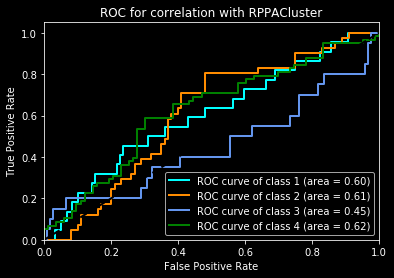

ROC AUC for RPPACluster class 1: 0.60
ROC AUC for RPPACluster class 2: 0.61
ROC AUC for RPPACluster class 3: 0.45
ROC AUC for RPPACluster class 4: 0.62


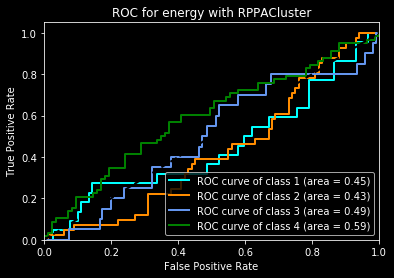

ROC AUC for RPPACluster class 1: 0.45
ROC AUC for RPPACluster class 2: 0.43
ROC AUC for RPPACluster class 3: 0.49
ROC AUC for RPPACluster class 4: 0.59


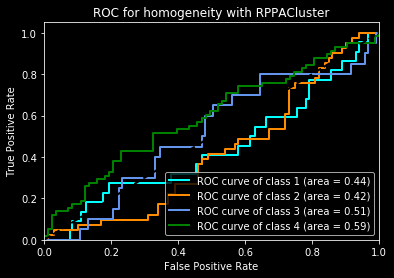

ROC AUC for RPPACluster class 1: 0.44
ROC AUC for RPPACluster class 2: 0.42
ROC AUC for RPPACluster class 3: 0.51
ROC AUC for RPPACluster class 4: 0.59


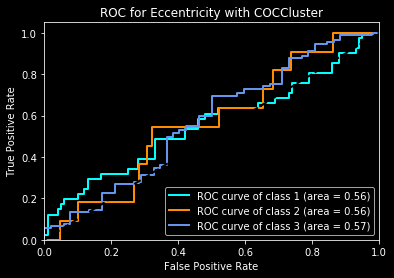

ROC AUC for COCCluster class 1: 0.56
ROC AUC for COCCluster class 2: 0.56
ROC AUC for COCCluster class 3: 0.57


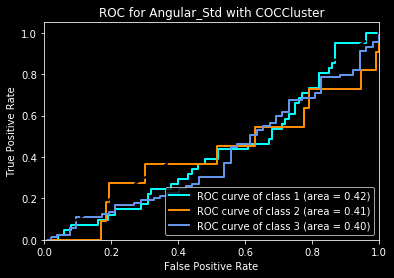

ROC AUC for COCCluster class 1: 0.42
ROC AUC for COCCluster class 2: 0.41
ROC AUC for COCCluster class 3: 0.40


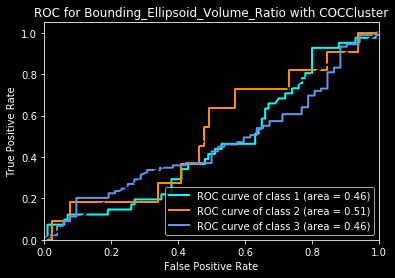

ROC AUC for COCCluster class 1: 0.46
ROC AUC for COCCluster class 2: 0.51
ROC AUC for COCCluster class 3: 0.46


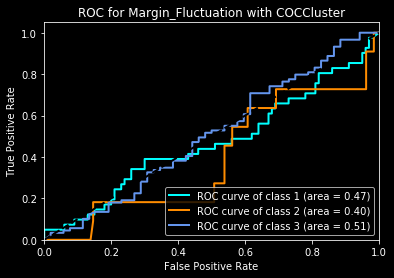

ROC AUC for COCCluster class 1: 0.47
ROC AUC for COCCluster class 2: 0.40
ROC AUC for COCCluster class 3: 0.51


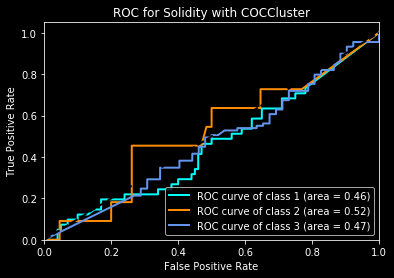

ROC AUC for COCCluster class 1: 0.46
ROC AUC for COCCluster class 2: 0.52
ROC AUC for COCCluster class 3: 0.47


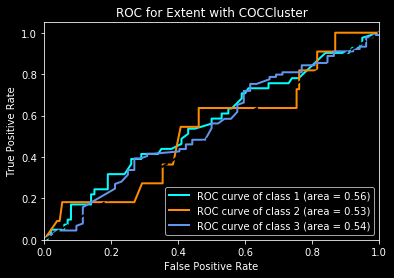

ROC AUC for COCCluster class 1: 0.56
ROC AUC for COCCluster class 2: 0.53
ROC AUC for COCCluster class 3: 0.54


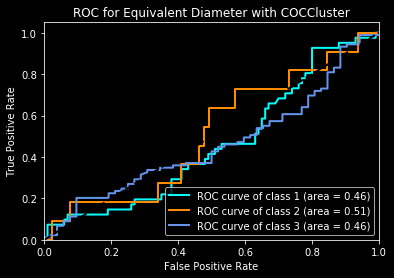

ROC AUC for COCCluster class 1: 0.46
ROC AUC for COCCluster class 2: 0.51
ROC AUC for COCCluster class 3: 0.46


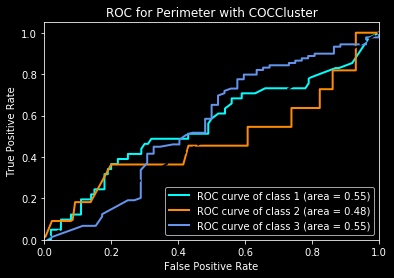

ROC AUC for COCCluster class 1: 0.55
ROC AUC for COCCluster class 2: 0.48
ROC AUC for COCCluster class 3: 0.55


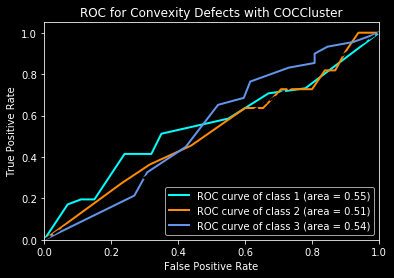

ROC AUC for COCCluster class 1: 0.55
ROC AUC for COCCluster class 2: 0.51
ROC AUC for COCCluster class 3: 0.54


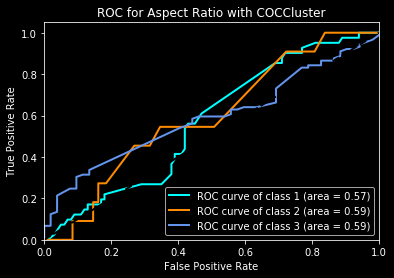

ROC AUC for COCCluster class 1: 0.57
ROC AUC for COCCluster class 2: 0.59
ROC AUC for COCCluster class 3: 0.59


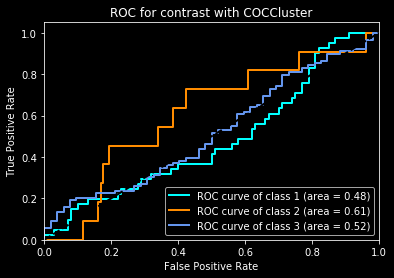

ROC AUC for COCCluster class 1: 0.48
ROC AUC for COCCluster class 2: 0.61
ROC AUC for COCCluster class 3: 0.52


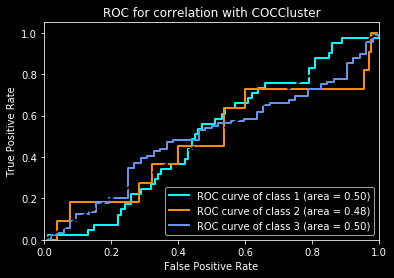

ROC AUC for COCCluster class 1: 0.50
ROC AUC for COCCluster class 2: 0.48
ROC AUC for COCCluster class 3: 0.50


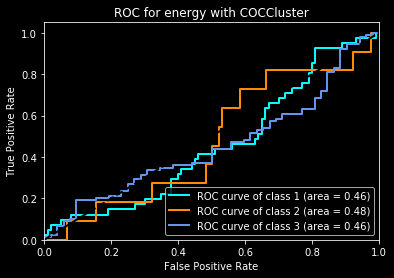

ROC AUC for COCCluster class 1: 0.46
ROC AUC for COCCluster class 2: 0.48
ROC AUC for COCCluster class 3: 0.46


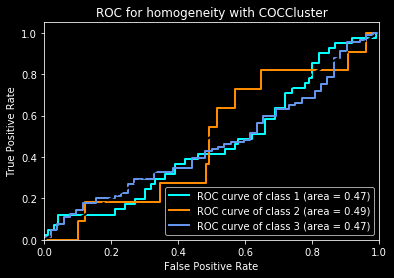

ROC AUC for COCCluster class 1: 0.47
ROC AUC for COCCluster class 2: 0.49
ROC AUC for COCCluster class 3: 0.47


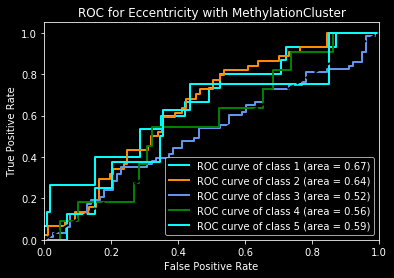

ROC AUC for MethylationCluster class 1: 0.67
ROC AUC for MethylationCluster class 2: 0.64
ROC AUC for MethylationCluster class 3: 0.52
ROC AUC for MethylationCluster class 4: 0.56
ROC AUC for MethylationCluster class 5: 0.59


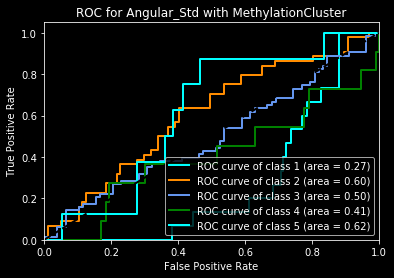

ROC AUC for MethylationCluster class 1: 0.27
ROC AUC for MethylationCluster class 2: 0.60
ROC AUC for MethylationCluster class 3: 0.50
ROC AUC for MethylationCluster class 4: 0.41
ROC AUC for MethylationCluster class 5: 0.62


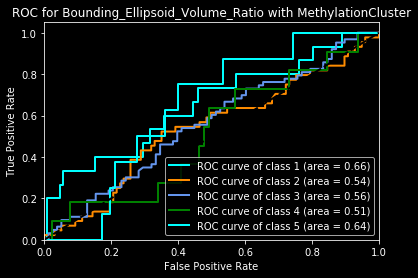

ROC AUC for MethylationCluster class 1: 0.66
ROC AUC for MethylationCluster class 2: 0.54
ROC AUC for MethylationCluster class 3: 0.56
ROC AUC for MethylationCluster class 4: 0.51
ROC AUC for MethylationCluster class 5: 0.64


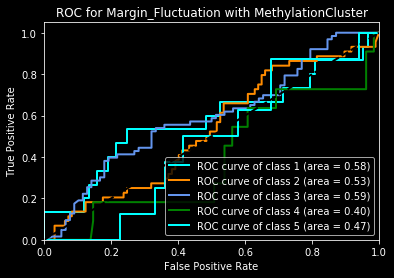

ROC AUC for MethylationCluster class 1: 0.58
ROC AUC for MethylationCluster class 2: 0.53
ROC AUC for MethylationCluster class 3: 0.59
ROC AUC for MethylationCluster class 4: 0.40
ROC AUC for MethylationCluster class 5: 0.47


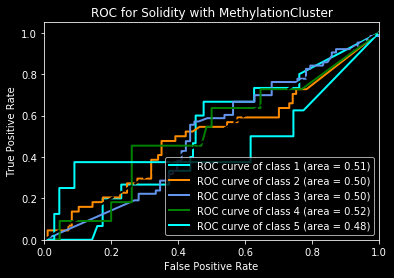

ROC AUC for MethylationCluster class 1: 0.51
ROC AUC for MethylationCluster class 2: 0.50
ROC AUC for MethylationCluster class 3: 0.50
ROC AUC for MethylationCluster class 4: 0.52
ROC AUC for MethylationCluster class 5: 0.48


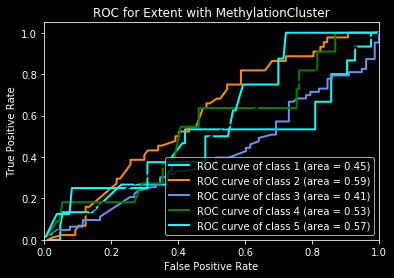

ROC AUC for MethylationCluster class 1: 0.45
ROC AUC for MethylationCluster class 2: 0.59
ROC AUC for MethylationCluster class 3: 0.41
ROC AUC for MethylationCluster class 4: 0.53
ROC AUC for MethylationCluster class 5: 0.57


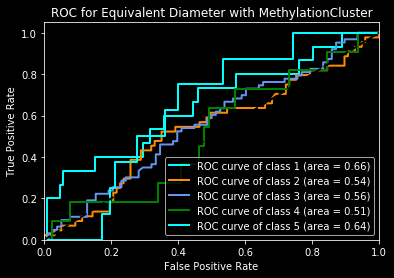

ROC AUC for MethylationCluster class 1: 0.66
ROC AUC for MethylationCluster class 2: 0.54
ROC AUC for MethylationCluster class 3: 0.56
ROC AUC for MethylationCluster class 4: 0.51
ROC AUC for MethylationCluster class 5: 0.64


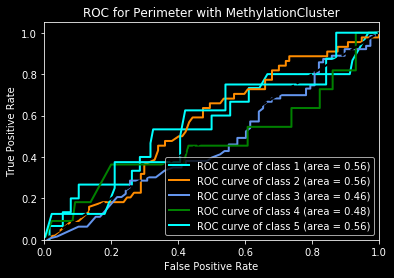

ROC AUC for MethylationCluster class 1: 0.56
ROC AUC for MethylationCluster class 2: 0.56
ROC AUC for MethylationCluster class 3: 0.46
ROC AUC for MethylationCluster class 4: 0.48
ROC AUC for MethylationCluster class 5: 0.56


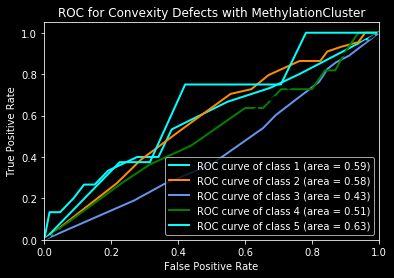

ROC AUC for MethylationCluster class 1: 0.59
ROC AUC for MethylationCluster class 2: 0.58
ROC AUC for MethylationCluster class 3: 0.43
ROC AUC for MethylationCluster class 4: 0.51
ROC AUC for MethylationCluster class 5: 0.63


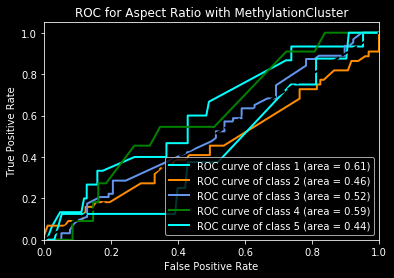

ROC AUC for MethylationCluster class 1: 0.61
ROC AUC for MethylationCluster class 2: 0.46
ROC AUC for MethylationCluster class 3: 0.52
ROC AUC for MethylationCluster class 4: 0.59
ROC AUC for MethylationCluster class 5: 0.44


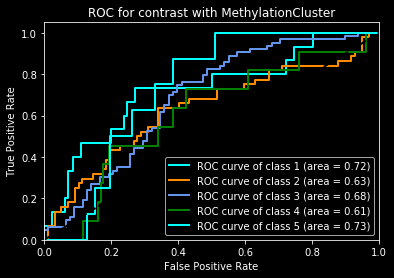

ROC AUC for MethylationCluster class 1: 0.72
ROC AUC for MethylationCluster class 2: 0.63
ROC AUC for MethylationCluster class 3: 0.68
ROC AUC for MethylationCluster class 4: 0.61
ROC AUC for MethylationCluster class 5: 0.73


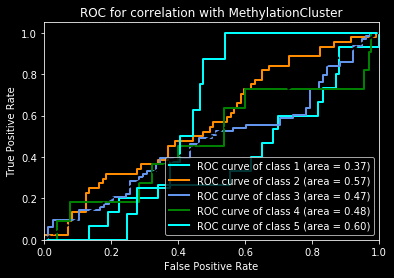

ROC AUC for MethylationCluster class 1: 0.37
ROC AUC for MethylationCluster class 2: 0.57
ROC AUC for MethylationCluster class 3: 0.47
ROC AUC for MethylationCluster class 4: 0.48
ROC AUC for MethylationCluster class 5: 0.60


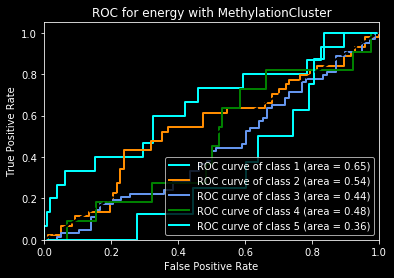

ROC AUC for MethylationCluster class 1: 0.65
ROC AUC for MethylationCluster class 2: 0.54
ROC AUC for MethylationCluster class 3: 0.44
ROC AUC for MethylationCluster class 4: 0.48
ROC AUC for MethylationCluster class 5: 0.36


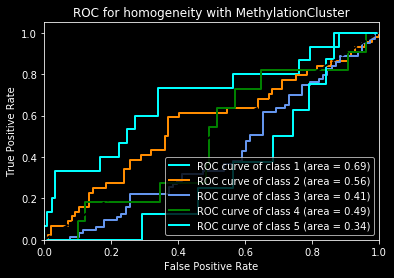

ROC AUC for MethylationCluster class 1: 0.69
ROC AUC for MethylationCluster class 2: 0.56
ROC AUC for MethylationCluster class 3: 0.41
ROC AUC for MethylationCluster class 4: 0.49
ROC AUC for MethylationCluster class 5: 0.34


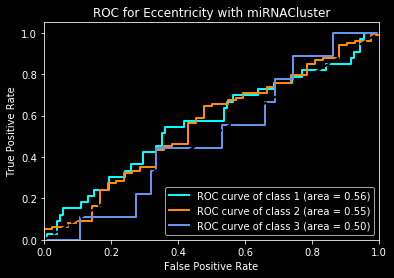

ROC AUC for miRNACluster class 1: 0.56
ROC AUC for miRNACluster class 2: 0.55
ROC AUC for miRNACluster class 3: 0.50


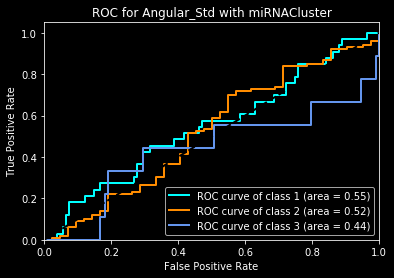

ROC AUC for miRNACluster class 1: 0.55
ROC AUC for miRNACluster class 2: 0.52
ROC AUC for miRNACluster class 3: 0.44


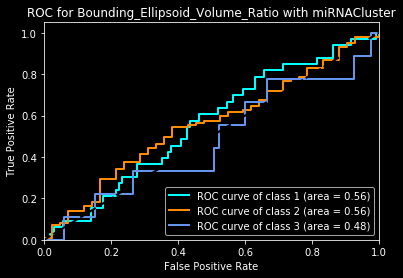

ROC AUC for miRNACluster class 1: 0.56
ROC AUC for miRNACluster class 2: 0.56
ROC AUC for miRNACluster class 3: 0.48


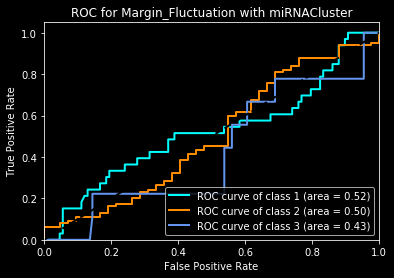

ROC AUC for miRNACluster class 1: 0.52
ROC AUC for miRNACluster class 2: 0.50
ROC AUC for miRNACluster class 3: 0.43


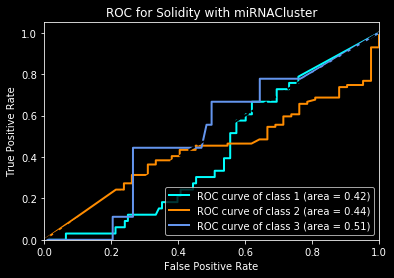

ROC AUC for miRNACluster class 1: 0.42
ROC AUC for miRNACluster class 2: 0.44
ROC AUC for miRNACluster class 3: 0.51


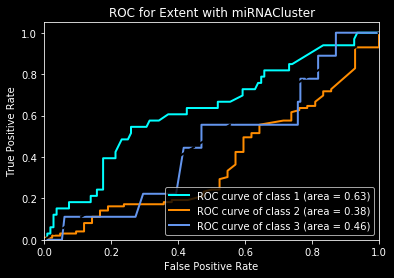

ROC AUC for miRNACluster class 1: 0.63
ROC AUC for miRNACluster class 2: 0.38
ROC AUC for miRNACluster class 3: 0.46


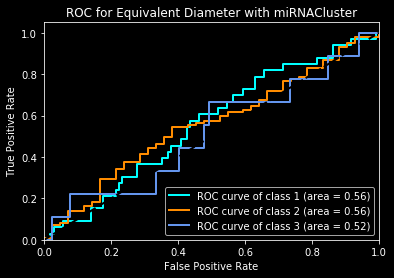

ROC AUC for miRNACluster class 1: 0.56
ROC AUC for miRNACluster class 2: 0.56
ROC AUC for miRNACluster class 3: 0.52


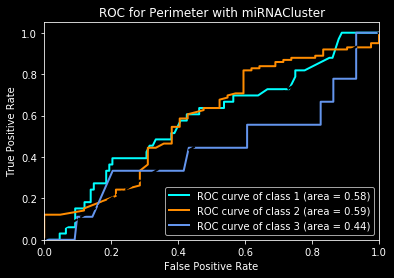

ROC AUC for miRNACluster class 1: 0.58
ROC AUC for miRNACluster class 2: 0.59
ROC AUC for miRNACluster class 3: 0.44


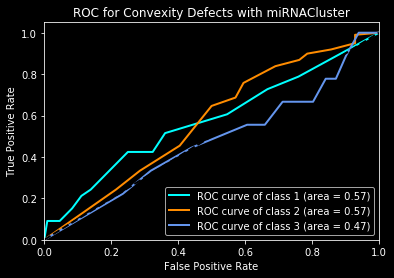

ROC AUC for miRNACluster class 1: 0.57
ROC AUC for miRNACluster class 2: 0.57
ROC AUC for miRNACluster class 3: 0.47


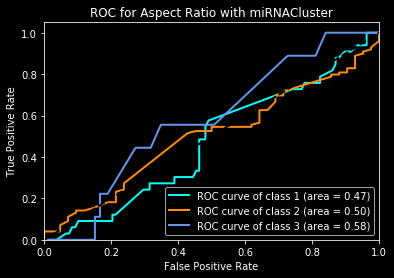

ROC AUC for miRNACluster class 1: 0.47
ROC AUC for miRNACluster class 2: 0.50
ROC AUC for miRNACluster class 3: 0.58


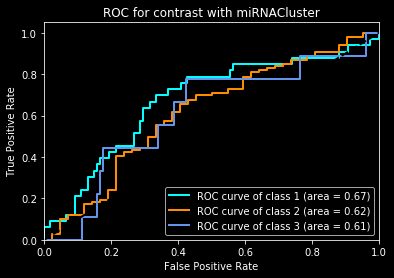

ROC AUC for miRNACluster class 1: 0.67
ROC AUC for miRNACluster class 2: 0.62
ROC AUC for miRNACluster class 3: 0.61


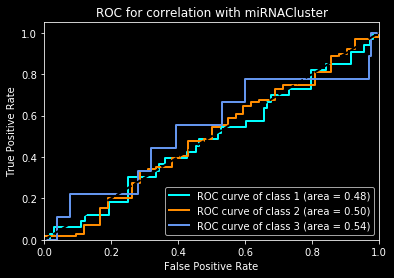

ROC AUC for miRNACluster class 1: 0.48
ROC AUC for miRNACluster class 2: 0.50
ROC AUC for miRNACluster class 3: 0.54


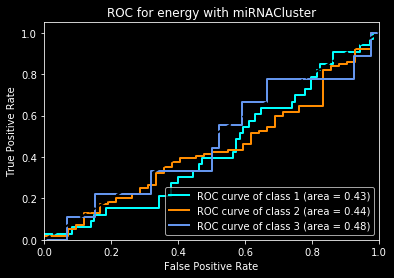

ROC AUC for miRNACluster class 1: 0.43
ROC AUC for miRNACluster class 2: 0.44
ROC AUC for miRNACluster class 3: 0.48


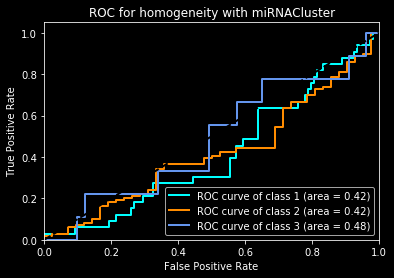

ROC AUC for miRNACluster class 1: 0.42
ROC AUC for miRNACluster class 2: 0.42
ROC AUC for miRNACluster class 3: 0.48


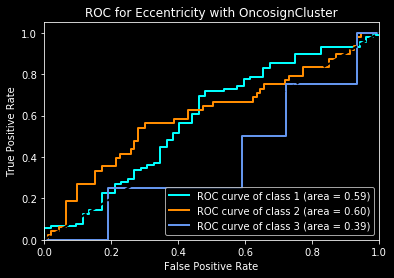

ROC AUC for OncosignCluster class 1: 0.59
ROC AUC for OncosignCluster class 2: 0.60
ROC AUC for OncosignCluster class 3: 0.39


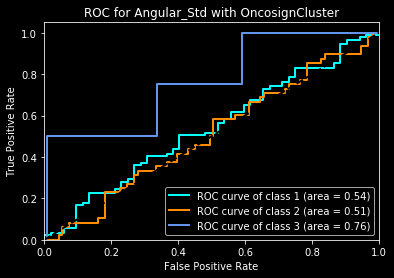

ROC AUC for OncosignCluster class 1: 0.54
ROC AUC for OncosignCluster class 2: 0.51
ROC AUC for OncosignCluster class 3: 0.76


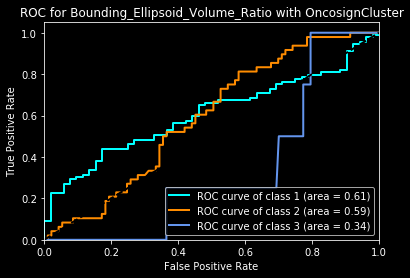

ROC AUC for OncosignCluster class 1: 0.61
ROC AUC for OncosignCluster class 2: 0.59
ROC AUC for OncosignCluster class 3: 0.34


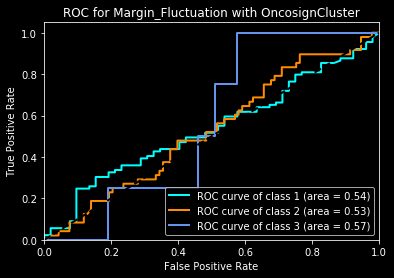

ROC AUC for OncosignCluster class 1: 0.54
ROC AUC for OncosignCluster class 2: 0.53
ROC AUC for OncosignCluster class 3: 0.57


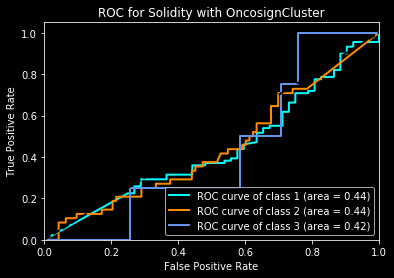

ROC AUC for OncosignCluster class 1: 0.44
ROC AUC for OncosignCluster class 2: 0.44
ROC AUC for OncosignCluster class 3: 0.42


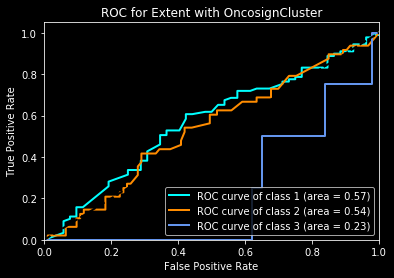

ROC AUC for OncosignCluster class 1: 0.57
ROC AUC for OncosignCluster class 2: 0.54
ROC AUC for OncosignCluster class 3: 0.23


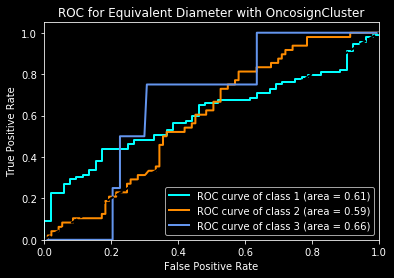

ROC AUC for OncosignCluster class 1: 0.61
ROC AUC for OncosignCluster class 2: 0.59
ROC AUC for OncosignCluster class 3: 0.66


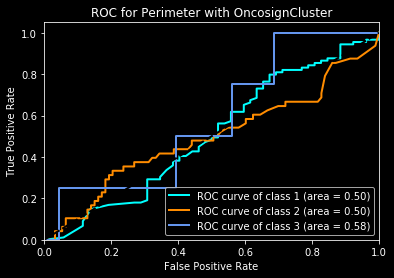

ROC AUC for OncosignCluster class 1: 0.50
ROC AUC for OncosignCluster class 2: 0.50
ROC AUC for OncosignCluster class 3: 0.58


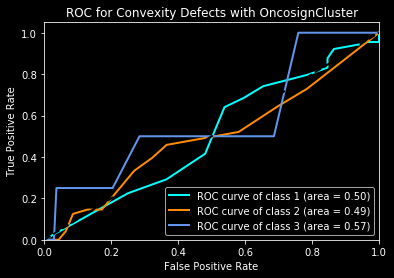

ROC AUC for OncosignCluster class 1: 0.50
ROC AUC for OncosignCluster class 2: 0.49
ROC AUC for OncosignCluster class 3: 0.57


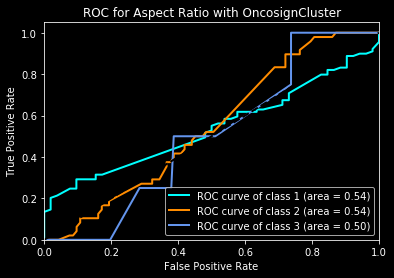

ROC AUC for OncosignCluster class 1: 0.54
ROC AUC for OncosignCluster class 2: 0.54
ROC AUC for OncosignCluster class 3: 0.50


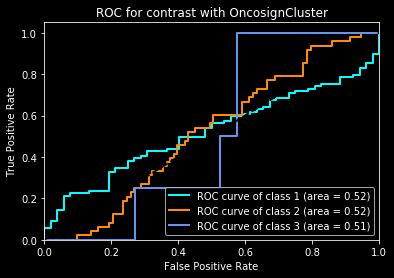

ROC AUC for OncosignCluster class 1: 0.52
ROC AUC for OncosignCluster class 2: 0.52
ROC AUC for OncosignCluster class 3: 0.51


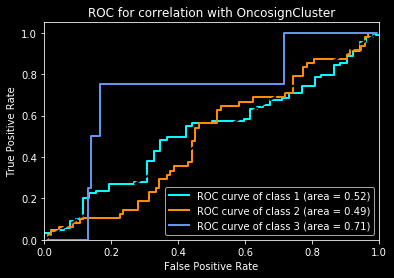

ROC AUC for OncosignCluster class 1: 0.52
ROC AUC for OncosignCluster class 2: 0.49
ROC AUC for OncosignCluster class 3: 0.71


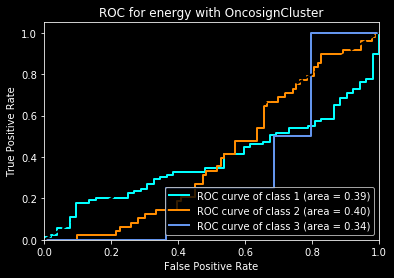

ROC AUC for OncosignCluster class 1: 0.39
ROC AUC for OncosignCluster class 2: 0.40
ROC AUC for OncosignCluster class 3: 0.34


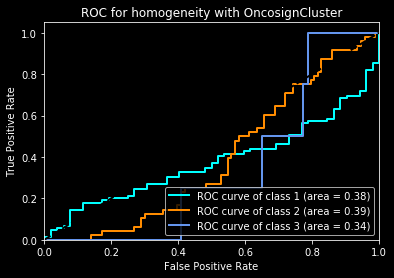

ROC AUC for OncosignCluster class 1: 0.38
ROC AUC for OncosignCluster class 2: 0.39
ROC AUC for OncosignCluster class 3: 0.34


In [54]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.pyplot as plt

# Assuming final_df is already created from the previous steps
# Let's clean the data and remove any NaN or infinite values

def clean_data(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

df = clean_data(df)

# Perform Fisher's exact test for each genomic subtype and each shape feature
genomic_subtypes = ["RNASeqCluster", "CNCluster", "RPPACluster", "COCCluster", "MethylationCluster", "miRNACluster", "OncosignCluster"]
shape_features = ["Eccentricity", "Angular_Std", "Bounding_Ellipsoid_Volume_Ratio", "Margin_Fluctuation", "Solidity", "Extent", "Equivalent Diameter", "Perimeter", "Convexity Defects", "Aspect Ratio", "contrast", "correlation", "energy", "homogeneity"]

p_values = {}

for feature in shape_features:
    p_values[feature] = {}
    for subtype in genomic_subtypes:
        median_feature = df[feature].median()
        high_feature_count = df.loc[(df[feature] > median_feature) & (df[subtype] == 1)].shape[0]
        low_feature_count = df.loc[(df[feature] <= median_feature) & (df[subtype] == 1)].shape[0]

        contingency_table = np.array([[max(high_feature_count, 0), max(low_feature_count, 0)],
                                      [len(df) - max(high_feature_count, 0), len(df) - max(low_feature_count, 0)]])
        oddsratio, p_value = fisher_exact(contingency_table)
        p_values[feature][subtype] = p_value

# Print p-values
print("P-values from Fisher's exact test:")
for feature, subtype_p_values in p_values.items():
    for subtype, p_val in subtype_p_values.items():
        print(f"Feature: {feature}, Subtype: {subtype}, P-value: {p_val}")

# Count the number of unique classes in each cluster
for cluster in genomic_subtypes:
    num_classes = df[cluster].nunique()
    print(f"{cluster} has {num_classes} unique classes.")

# ROC AUC calculation for shape features with genomic clusters
def calculate_roc_auc(X, y, feature_name, cluster_name):
    # Remove any rows with NaN values in X or y
    valid_idx = np.isfinite(X).all(axis=1) & np.isfinite(y)
    X = X[valid_idx]
    y = y[valid_idx]

    # Binarize the output for multiclass
    y_bin = label_binarize(y, classes=np.unique(y))
    n_classes = y_bin.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.5, random_state=42)
    
    classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    if n_classes > 2:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure()
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'ROC curve of class {i+1} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {feature_name} with {cluster_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Print the ROC AUC scores
    for i in range(n_classes):
        print(f"ROC AUC for {cluster_name} class {i+1}: {roc_auc[i]:.2f}")

# Perform ROC AUC calculations
for subtype in genomic_subtypes:
    for feature in shape_features:
        X = df[[feature]].values
        y = df[subtype].values
        calculate_roc_auc(X, y, feature, subtype)

In [54]:
# Perform Fisher's exact test for each genomic subtype and each shape feature
genomic_subtypes = ["RNASeqCluster", "CNCluster", "RPPACluster", "COCCluster", "MethylationCluster", "miRNACluster", "OncosignCluster"]
shape_features = ["Eccentricity", "Angular_Std", "Bounding_Ellipsoid_Volume_Ratio", "Margin_Fluctuation", "Solidity", "Extent", "Equivalent Diameter", "Perimeter", "Convexity Defects", "Aspect Ratio", "contrast", "correlation", "energy", "homogeneity"]
p_values = {}

for feature in shape_features:
    p_values[feature] = {}
    for subtype in genomic_subtypes:
        median_feature = df[feature].median()
        high_feature_count = df.loc[(df[feature] > median_feature) & (df[subtype] == 1)].shape[0]
        low_feature_count = df.loc[(df[feature] <= median_feature) & (df[subtype] == 1)].shape[0]

        contingency_table = np.array([[max(high_feature_count, 0), max(low_feature_count, 0)],
                                      [len(df) - max(high_feature_count, 0), len(df) - max(low_feature_count, 0)]])
        oddsratio, p_value = fisher_exact(contingency_table)
        p_values[feature][subtype] = p_value

In [55]:
# Apply Bonferroni correction
p_values_corrected = {}
for feature in shape_features:
    p_values_corrected[feature] = multipletests(list(p_values[feature].values()), method='bonferroni')[1]

In [56]:
# Print p-values
for feature in shape_features:
    print(f"P-values for {feature}:")
    for i, subtype in enumerate(genomic_subtypes):
        print(f"    P-value for {subtype}: {p_values_corrected[feature][i]}")

P-values for Eccentricity:
    P-value for RNASeqCluster: 1.0
    P-value for CNCluster: 1.0
    P-value for RPPACluster: 1.0
    P-value for COCCluster: 1.0
    P-value for MethylationCluster: 1.0
    P-value for miRNACluster: 0.5392094430575571
    P-value for OncosignCluster: 0.046364315463583085
P-values for Angular_Std:
    P-value for RNASeqCluster: 0.5850118593426955
    P-value for CNCluster: 1.0
    P-value for RPPACluster: 1.0
    P-value for COCCluster: 1.0
    P-value for MethylationCluster: 1.0
    P-value for miRNACluster: 0.34565921284823176
    P-value for OncosignCluster: 0.10732390094451638
P-values for Bounding_Ellipsoid_Volume_Ratio:
    P-value for RNASeqCluster: 0.10634033592669126
    P-value for CNCluster: 1.0
    P-value for RPPACluster: 1.0
    P-value for COCCluster: 1.0
    P-value for MethylationCluster: 1.0
    P-value for miRNACluster: 1.0
    P-value for OncosignCluster: 1.0
P-values for Margin_Fluctuation:
    P-value for RNASeqCluster: 1.0
    P-value 

In [40]:

    for subtype in genomic_subtypes:
        if subtype != "RNASeqCluster":
            y_true = (df[subtype] == 1).astype(int)
            y_score = df[feature].fillna(df[feature].median())  # Fill missing values with median
            roc_auc = roc_auc_score(y_true, y_score)
            roc_auc_scores[feature][subtype + "_vs_All"] = roc_auc
            
            # Calculate p-values
            median_feature = df[feature].median()
            high_feature_count = df.loc[(df[feature] > median_feature) & (df[subtype] == 1)].shape[0]
            low_feature_count = df.loc[(df[feature] <= median_feature) & (df[subtype] == 1)].shape[0]

            contingency_table = np.array([[max(high_feature_count, 0), max(low_feature_count, 0)],
                                          [len(df) - max(high_feature_count, 0), len(df) - max(low_feature_count, 0)]])
            oddsratio, p_value = fisher_exact(contingency_table)
            p_values[feature][subtype] = p_value

# Apply Bonferroni correction
p_values_corrected = {}
for feature in shape_features:
    p_values_corrected[feature] = multipletests(list(p_values[feature].values()), method='bonferroni')[1]

# Print p-values and ROC AUC scores
for feature in shape_features:
    print(f"P-values for {feature} vs RNASeqCluster:")
    for subtype in genomic_subtypes:
        if subtype != "RNASeqCluster":
            print(f"    P-value for {subtype}: {p_values_corrected[feature][genomic_subtypes.index(subtype)]}")
    print(f"ROC AUC score for {feature} vs RNASeqCluster (1, 2, 3, 4): {roc_auc_scores[feature]['RNASeqCluster_1_2_3_4_vs_All']}")


KeyError: 'Eccentricity'

In [76]:
# Initialize lists to store results
eccentricity_list = []

# Perform segmentation and analysis for each patient with diagnosis = 1
for index, row in df[df["diagnosis"] == 1].iterrows():
    # Load mask
    mask = cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE)
    
    # Calculate eccentricity for each mask
    ecc = eccentricity(mask)
    
    # Store eccentricity value
    eccentricity_list.append(ecc)

# Calculate the average eccentricity
average_eccentricity = np.nanmean(eccentricity_list)
print("Average Eccentricity:", average_eccentricity)

Average Eccentricity: 0.7463126696283879


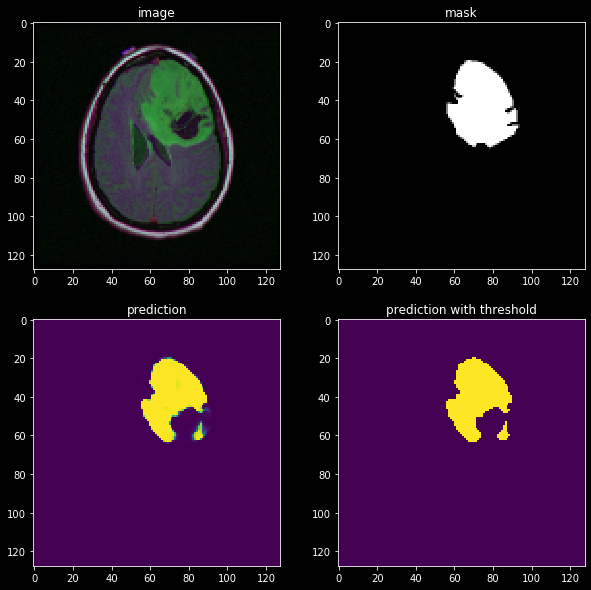

In [451]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

### Predictive overlapping on test images

In [ ]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values


def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    #model.eval():
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[1]),(128, 128))
        image =  image / 255.

        # gt
        ground_truth = cv2.resize(cv2.imread(test_sample[2], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.#1.0
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[1]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
    
#prediction_overlap_u = batch_preds_overlap(unet, test_samples)
#prediction_overlap_f = batch_preds_overlap(fpn, test_samples)
prediction_overlap_r = batch_preds_overlap(rx50, test_samples)

## Plates of images of predictive overlapping

In [ ]:
# DATA

# unet plates
#pred_overlap_5x1_u = []
#pred_overlap_5x3_u = []

# fpn plates
#pred_overlap_5x1_f = []
#pred_overlap_5x3_f = []

# rx plates
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    #pred_overlap_5x1_u.append(np.hstack(np.array(prediction_overlap_u[i-5:i])))
    #pred_overlap_5x1_f.append(np.hstack(np.array(prediction_overlap_f[i-5:i])))
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
   #pred_overlap_5x3_u.append(np.vstack(pred_overlap_5x1_u[i-3:i]))
   #pred_overlap_5x3_f.append(np.vstack(pred_overlap_5x1_f[i-3:i]))
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [ ]:
# PLOT

def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

    

title1 = "Predictions of Vanilla UNet"
title2 = "Predictions of FPN"
title3 = "Predictions of UNet with ResNeXt50 backbone"

for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title3, num)
    

"""for num, (batch1, batch2, batch3) in enumerate(zip(
    pred_overlap_5x3_u, pred_overlap_5x3_f, pred_overlap_5x3_r)):
    
    plot_plate_overlap(batch1,title1, num)   
    plot_plate_overlap(batch2,title2, num)
    plot_plate_overlap(batch3,title3, num)""";

# Gifs

In [ ]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), 
                                  key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

#fn1 = make_gif(title1)
#fn2 = make_gif(title2)
fn3 = make_gif(title3)

### Display gifs


In [ ]:
from IPython.display import Image as Image_display

In [ ]:
"""with open(fn1,'rb') as f:
    display(Image_display(data=f.read(), format='png'))""";

In [ ]:
"""with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))""";

In [ ]:
with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))

# What's next?

Experiments:
+  More epochs for training iterations(train longer, without overfitting)
+  Experimenting with different input image size.
+  Experimenting with different batch size.
+  Experimenting with different learning rate.
+  Strong image transforms.
+  Experiments with different UNet backbone
+ Overfits

Fine tuning:
+ Lovasz-Loss
+ lr Schedulers
